### Setup
Always run these cells before everything else

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%load_ext autoreload
%autoreload 2

In [ ]:
# SETUP AND IMPORTS
import sys

wd_path = "/home/dk538/rds/hpc-work/pico"
sys.path.append(wd_path)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from utils.data_utils import Manual, process_data

# from models.baselines import SingleGeneLasso, SingleGeneLinear, SingleGeneSVR
from functools import partial
from utils.comptools import rep_renamer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

import matplotlib.font_manager as fm
import urllib.request

from utils.comp_utils import PerfComp

# We use Source Sans 3 font for all figures
# Download the font
font_url = "https://github.com/adobe-fonts/source-sans/blob/release/TTF/SourceSans3-Regular.ttf?raw=True"
font_path = f"{wd_path}/results_analysis/figures/SourceSans3-Regular.ttf"  # Specify where to save the font
font_bold_url = "https://github.com/adobe-fonts/source-sans/blob/release/TTF/SourceSans3-Bold.ttf?raw=True"
font_bold_path = f"{wd_path}/results_analysis/figures/SourceSans3-Bold.ttf"  # Specify where to save the font
font_it_url = "https://github.com/adobe-fonts/source-sans/blob/release/TTF/SourceSans3-It.ttf?raw=True"
font_it_path = f"{wd_path}/results_analysis/figures/SourceSans3-It.ttf"  # Specify where to save the font
urllib.request.urlretrieve(font_url, font_path)
urllib.request.urlretrieve(font_bold_url, font_bold_path)
urllib.request.urlretrieve(font_it_url, font_it_path)

# If the font is not available, in a terminal, run the below:
# cp ~/rds/hpc-work/graphdep/results_analysis/figures/*ttf ~/.local/share/fonts
# fc-cache -f -v
# rm -fr ~/.cache/matplotlib

# Then restart Jupyter kernel

fm.findfont("Source Sans 3", rebuild_if_missing=True)

# Set font globally for Matplotlib
from matplotlib import rc

plt.style.use("default")
sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    rc={
        "axes.linewidth": 1,
        "xtick.major.width": 1,
        "ytick.major.width": 1,
        "axes.edgecolor": "grey",
        "xtick.labelcolor": "black",
        "xtick.color": "grey",
        "ytick.labelcolor": "black",
        "ytick.color": "grey",
    },
)

rc("font", **{"family": "sans-serif", "sans-serif": ["Source Sans 3"]})
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Source Sans 3:italic"


def type_renamer(x):
    x = "_".join((x.split(" ")))
    return "_".join(x.split("/"))

/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 iCoVAE representations

## 1.0 Data loading and summaries

### 1.0.1 Data loading

In [12]:
dataset_name = "depmap_gdsc"

# PROCESS DATASET
x, s, c, y, test_samples = process_data(
    dataset=dataset_name, wd_path=wd_path, experiment="h16"
)

dataset_params = {"var_filt_x": 1, "var_filt_s": None}

dataset = Manual(
    x=x, s=s, y=y, constraints=["EGFR"], target="LAPATINIB", params=dataset_params
)

499
184
520
247

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 1)
y                                  (1450, 1)
--------------------------------------------------


In [13]:
print(len(dataset.x_s_y_samples))
print(len(dataset.x_s_samples))
print(len(dataset.x_y_samples))
print(len(dataset.x_only_samples))
print(len(test_samples))

499
520
184
247
397


### 1.0.2 Sample summaries

In [17]:
model = pd.read_csv(f"{wd_path}/data/depmap23q2/Model.csv")

model["OncotreeLineage"] = model["OncotreeLineage"].map(type_renamer)

model = model.set_index("ModelID")

lineage_labels = {
    "Bone": "Bone",
    "Peripheral_Nervous_System": "PNS",
    "Liver": "Liver",
    "Cervix": "Cervix",
    "Kidney": "Kidney",
    "Bladder_Urinary_Tract": "Bladder/UT",
    "Prostate": "Prostate",
    "Lung": "Lung",
    "Lymphoid": "Lymphoid",
    "CNS_Brain": "CNS/Brain",
    "Skin": "Skin",
    "Esophagus_Stomach": "Esophagus/Stomach",
    "Bowel": "Bowel",
    "Ovary_Fallopian_Tube": "Ovary/Fallopian Tube",
    "Head_and_Neck": "Head and Neck",
    "Pancreas": "Pancreas",
    "Breast": "Breast",
    "Soft_Tissue": "Soft Tissue",
    "Biliary_Tract": "Biliary Tract",
    "Eye": "Eye",
    "Thyroid": "Thyroid",
    "Ampulla_of_Vater": "Ampulla of Vater",
    "Testis": "Testis",
    "Vulva_Vagina": "Vulva/Vagina",
    "Myeloid": "Myeloid",
    "Uterus": "Uterus",
    "Fibroblast": "Fibroblast",
    "Pleura": "Pleura",
    "Adrenal_Gland": "Adrenal Gland",
}

pal = sns.color_palette("colorblind")

              OncotreeLineage  count
11                       Lung     87
7           Esophagus_Stomach     43
12                   Lymphoid     41
5                   CNS_Brain     35
3                       Bowel     34
4                      Breast     29
14       Ovary_Fallopian_Tube     28
15                   Pancreas     25
19                       Skin     23
8               Head_and_Neck     21
13                    Myeloid     17
16  Peripheral_Nervous_System     14
23                     Uterus     14
1       Bladder_Urinary_Tract     13
10                      Liver     12
2                        Bone     12
9                      Kidney     11
22                    Thyroid      9
6                      Cervix      9
20                Soft_Tissue      8
17                     Pleura      6
18                   Prostate      5
0               Biliary_Tract      1
21                     Testis      1
24               Vulva_Vagina      1


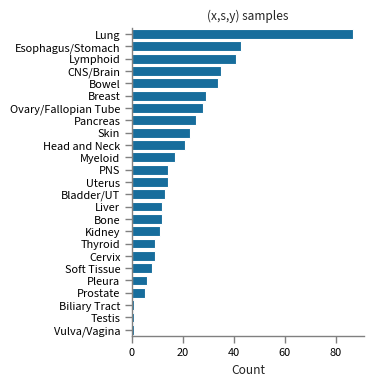

In [18]:
x_s_y_lineage = model.loc[dataset.x_s_y_samples][["OncotreeLineage"]]
x_s_y_lineage = (
    x_s_y_lineage.groupby("OncotreeLineage").size().reset_index(name="count")
)
x_s_y_lineage = x_s_y_lineage.sort_values("count", ascending=False)
print(x_s_y_lineage)
f, ax = plt.subplots(1, 1, figsize=(3, 4))
x_s_y_lineage_plot = x_s_y_lineage.copy()
x_s_y_lineage_plot["OncotreeLineage"] = x_s_y_lineage_plot["OncotreeLineage"].map(
    lambda x: lineage_labels[x]
)
sns.barplot(data=x_s_y_lineage_plot, y="OncotreeLineage", x="count", color=pal[0])
sns.despine()
ax.set_xlabel("Count")
ax.set_ylabel("")
ax.set_title("(x,s,y) samples")
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_s_y_lineages.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_s_y_lineages.png",
    bbox_inches="tight",
    dpi=600,
)

              OncotreeLineage  count
21                       Skin     47
6                   CNS_Brain     47
14                   Lymphoid     35
10              Head_and_Neck     35
1               Biliary_Tract     33
13                       Lung     30
22                Soft_Tissue     27
16       Ovary_Fallopian_Tube     26
4                       Bowel     21
17                   Pancreas     20
18  Peripheral_Nervous_System     19
25                     Uterus     19
2       Bladder_Urinary_Tract     19
11                     Kidney     18
15                    Myeloid     18
5                      Breast     16
3                        Bone     16
8           Esophagus_Stomach     15
9                         Eye     14
19                     Pleura     13
12                      Liver     12
7                      Cervix      9
20                   Prostate      4
0            Ampulla_of_Vater      4
24                    Thyroid      2
23                     Testis      1


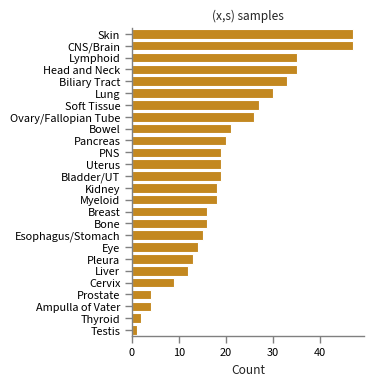

In [19]:
x_s_lineage = model.loc[dataset.x_s_samples][["OncotreeLineage"]]
x_s_lineage = x_s_lineage.groupby("OncotreeLineage").size().reset_index(name="count")
x_s_lineage = x_s_lineage.sort_values("count", ascending=False)
print(x_s_lineage)
f, ax = plt.subplots(1, 1, figsize=(3, 4))
x_s_lineage_plot = x_s_lineage.copy()
x_s_lineage_plot["OncotreeLineage"] = x_s_lineage_plot["OncotreeLineage"].map(
    lambda x: lineage_labels[x]
)
sns.barplot(data=x_s_lineage_plot, y="OncotreeLineage", x="count", color=pal[1])
sns.despine()
ax.set_xlabel("Count")
ax.set_ylabel("")
ax.set_title("(x,s) samples")
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_s_y_lineages.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_s_lineages.png",
    bbox_inches="tight",
    dpi=600,
)

              OncotreeLineage  count
12                       Lung     43
13                   Lymphoid     39
4                      Breast     15
14                    Myeloid     14
20                       Skin     13
3                       Bowel      8
7           Esophagus_Stomach      8
10                     Kidney      7
15       Ovary_Fallopian_Tube      6
2                        Bone      4
23                    Thyroid      3
21                Soft_Tissue      3
17  Peripheral_Nervous_System      3
16                   Pancreas      3
1       Bladder_Urinary_Tract      3
24                     Uterus      2
5                   CNS_Brain      2
11                      Liver      1
9               Head_and_Neck      1
18                     Pleura      1
19                   Prostate      1
8                  Fibroblast      1
6                      Cervix      1
22                     Testis      1
0               Adrenal_Gland      1


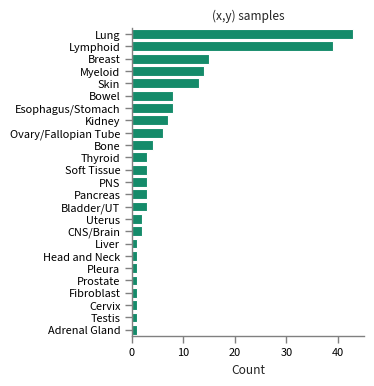

In [20]:
x_y_lineage = model.loc[dataset.x_y_samples][["OncotreeLineage"]]
x_y_lineage = x_y_lineage.groupby("OncotreeLineage").size().reset_index(name="count")
x_y_lineage = x_y_lineage.sort_values("count", ascending=False)
print(x_y_lineage)
f, ax = plt.subplots(1, 1, figsize=(3, 4))
x_y_lineage_plot = x_y_lineage.copy()
x_y_lineage_plot["OncotreeLineage"] = x_y_lineage_plot["OncotreeLineage"].map(
    lambda x: lineage_labels[x]
)
sns.barplot(data=x_y_lineage_plot, y="OncotreeLineage", x="count", color=pal[2])
sns.despine()
ax.set_xlabel("Count")
ax.set_ylabel("")
ax.set_title("(x,y) samples")
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_s_y_lineages.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_y_lineages.png",
    bbox_inches="tight",
    dpi=600,
)

              OncotreeLineage  count
14                   Lymphoid     42
9                  Fibroblast     37
13                       Lung     31
7           Esophagus_Stomach     18
15                    Myeloid     13
3                       Bowel     13
5                   CNS_Brain     13
17                   Pancreas     10
2                        Bone      8
4                      Breast      8
11                     Kidney      7
22                Soft_Tissue      6
21                       Skin      6
16       Ovary_Fallopian_Tube      6
24                     Uterus      5
0               Biliary_Tract      4
8                         Eye      4
18  Peripheral_Nervous_System      3
10              Head_and_Neck      3
1       Bladder_Urinary_Tract      2
20                   Prostate      2
23                    Thyroid      2
12                      Liver      1
19                     Pleura      1
6                      Cervix      1
25               Vulva_Vagina      1


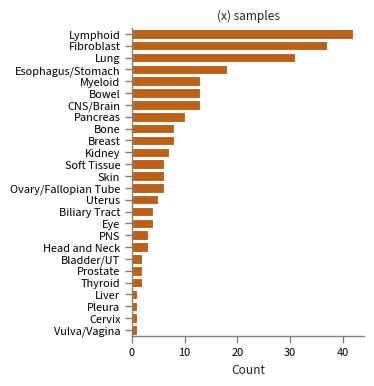

In [21]:
x_only_lineage = model.loc[dataset.x_only_samples][["OncotreeLineage"]]
x_only_lineage = (
    x_only_lineage.groupby("OncotreeLineage").size().reset_index(name="count")
)
x_only_lineage = x_only_lineage.sort_values("count", ascending=False)
print(x_only_lineage)
f, ax = plt.subplots(1, 1, figsize=(3, 4))
x_only_lineage_plot = x_only_lineage.copy()
x_only_lineage_plot["OncotreeLineage"] = x_only_lineage_plot["OncotreeLineage"].map(
    lambda x: lineage_labels[x]
)
sns.barplot(data=x_only_lineage_plot, y="OncotreeLineage", x="count", color=pal[3])
sns.despine()
ax.set_xlabel("Count")
ax.set_ylabel("")
ax.set_title("(x) samples")
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_s_y_lineages.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_x_only_lineages.png",
    bbox_inches="tight",
    dpi=600,
)

## 1.1 Evaluating representations

### 1.1.1 Representation PCA

AZD6738
RAD9A RAD1 HUS1 CCL16 RNASEH2C H2AZ1 PSMA2 CNN2 POP5 RAD17 TFIP11 VCP PSMC4 POMP ZNF830 PTPMT1
497
181
522
250

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 16)
y                                  (1450, 1)
--------------------------------------------------
44
            Unnamed: 0   ind       z_0       z_1       z_2       z_3  \
ModelID                                                                
ACH-000859           1   751  0.376183  0.757508  1.947863  0.016920   
ACH-000849           2  1236  0.852721  0.212747  1.845178  0.098176   
ACH-000212           5  1216 -1.159080 -0.641124 -0.603789  0.441811   
ACH-000147           6  1007  1.478743 -0.253150  0.188458  0.657366   
ACH-000856           8    82  0.571639 -0.273405 -0.252962  0.662362   
ACH-0

/tmp/ipykernel_2092213/1369159259.py:470: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_1, axes_1 = plt.subplots(1, 2, figsize=(8, 3))


45
            Unnamed: 0   ind       z_0       z_1       z_2       z_3  \
ModelID                                                                
ACH-000196           1   324 -0.255410 -0.358842  1.174712 -0.151411   
ACH-000849           2  1236 -0.738363 -0.159767  0.722279 -0.346843   
ACH-000930           3  1008 -0.307702 -0.169872 -0.084207 -0.706950   
ACH-000624           4  1050 -0.116019  0.674965  0.704126  0.547106   
ACH-000117           5    55 -0.464654 -0.179723 -0.335578  0.482020   
ACH-000212           6  1216 -0.123318 -0.320391 -0.858988 -0.188315   
ACH-000276          10    73  0.038088 -0.431705  0.333802 -0.325238   
ACH-000554          11    65 -0.043103 -0.508025  0.058841 -0.339783   
ACH-000755          12   628  0.333211  0.286768 -0.553083  0.065080   
ACH-000573          13   851 -1.130225  0.262536  0.687784 -1.310553   
ACH-000828          14    22  0.010981 -0.041746 -0.738776  0.331684   
ACH-000711          15   237 -0.423996  0.153618  0.241350 -0

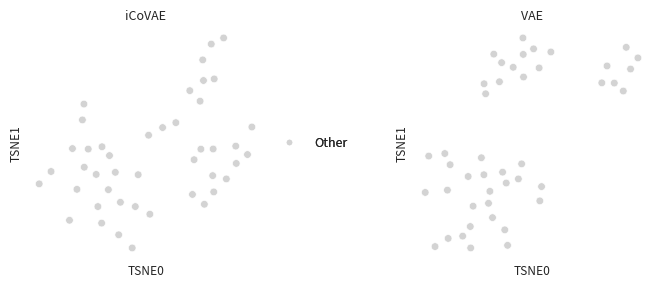

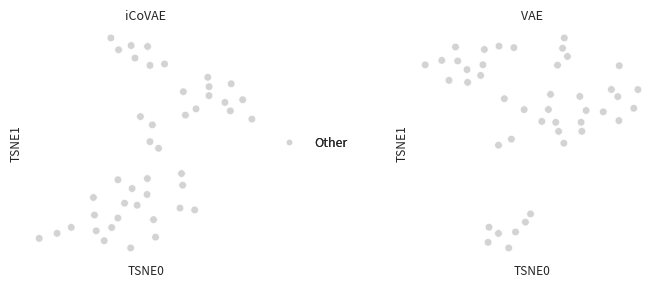

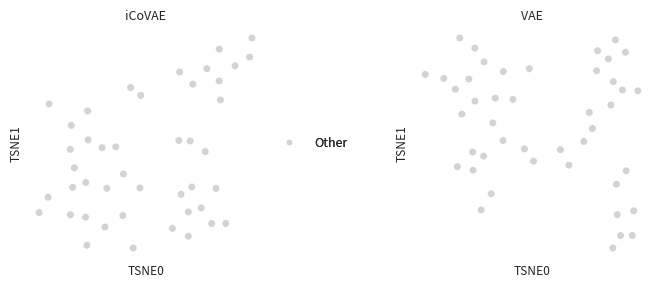

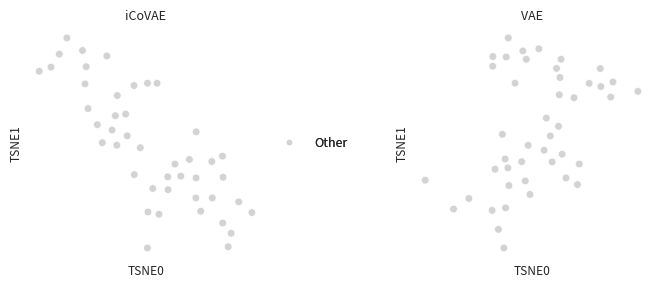

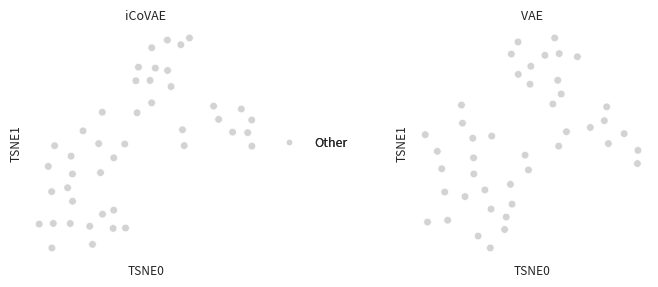

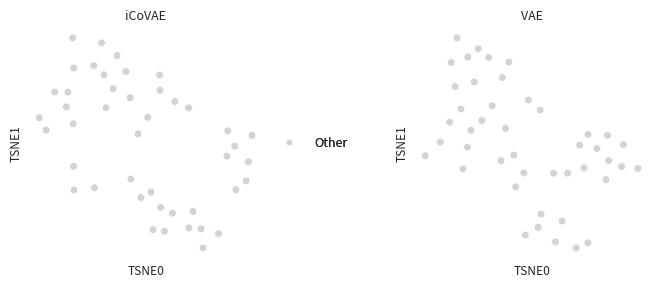

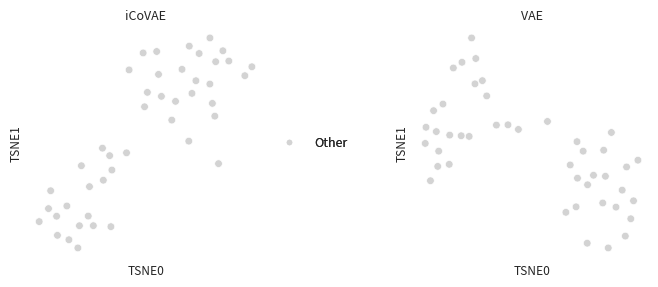

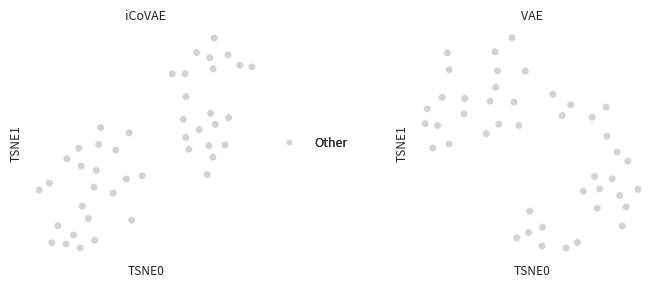

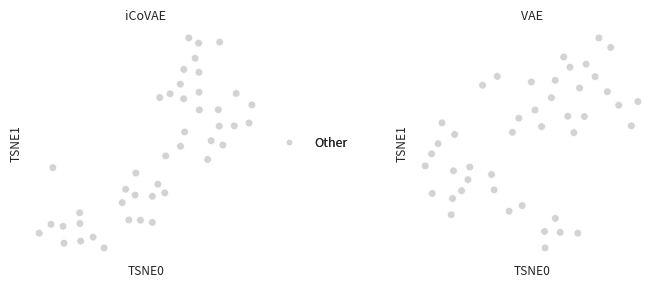

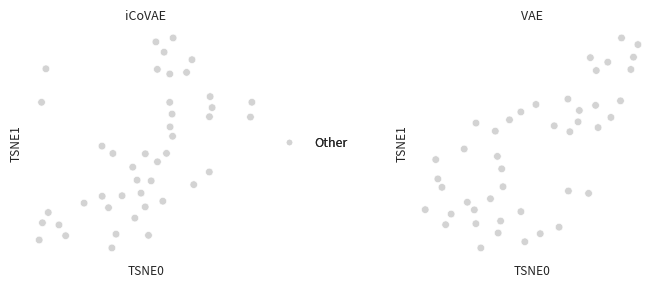

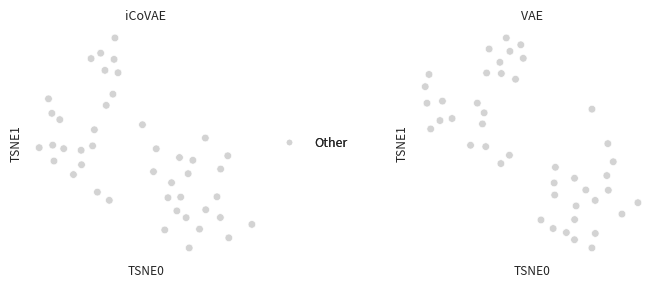

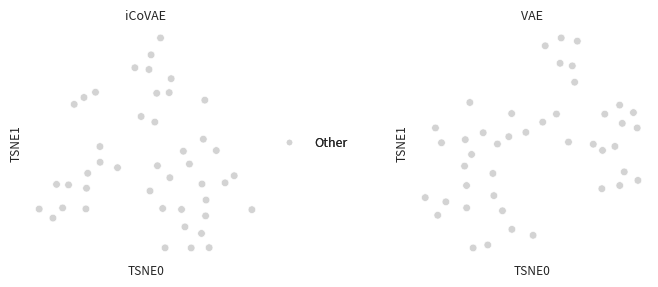

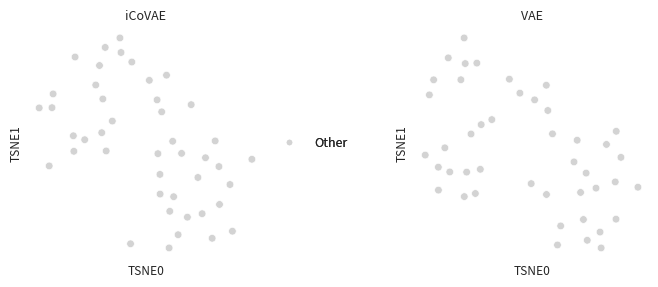

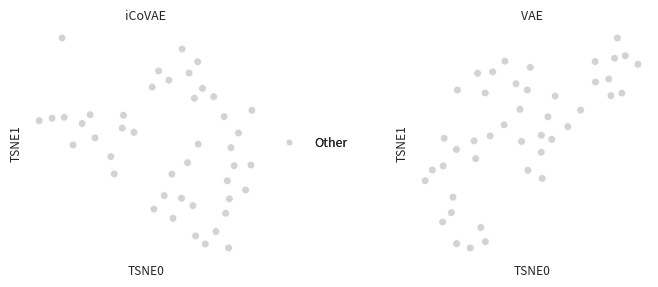

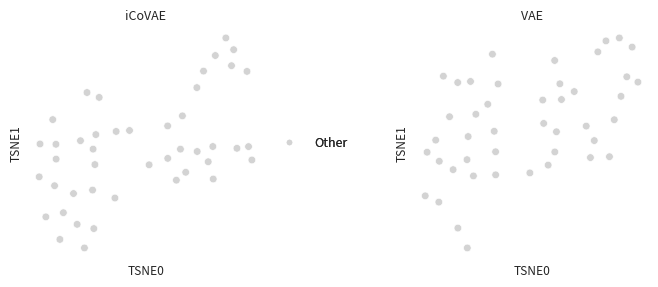

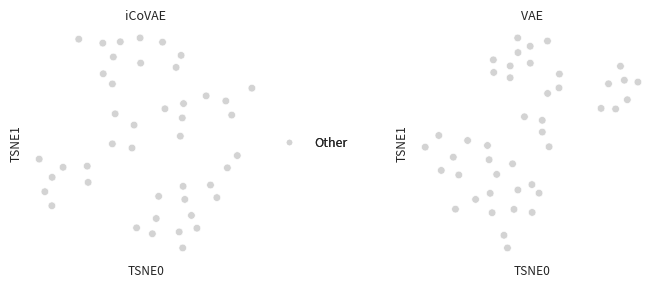

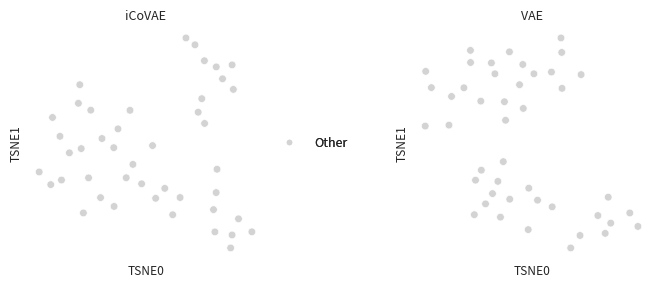

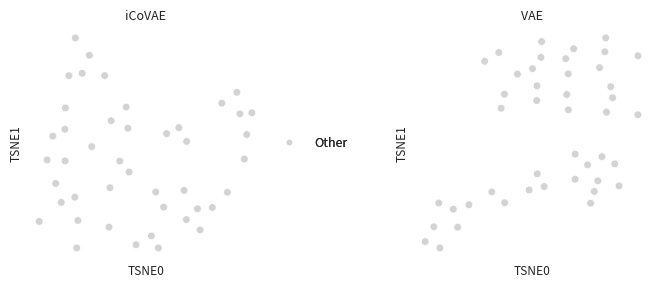

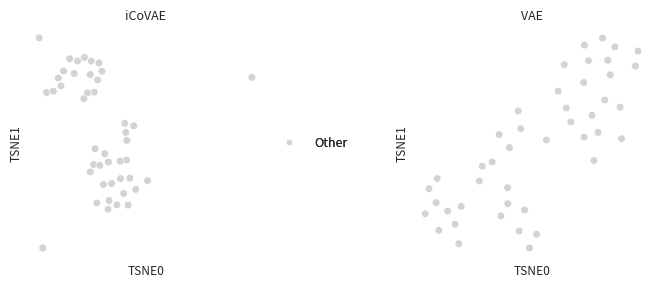

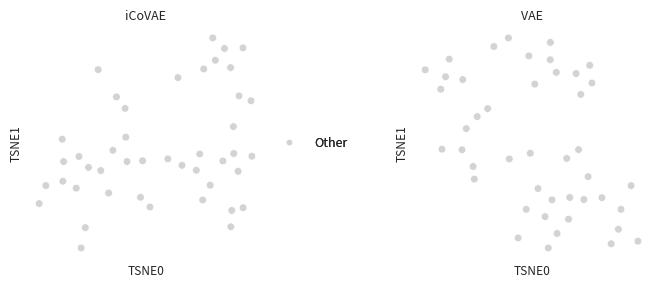

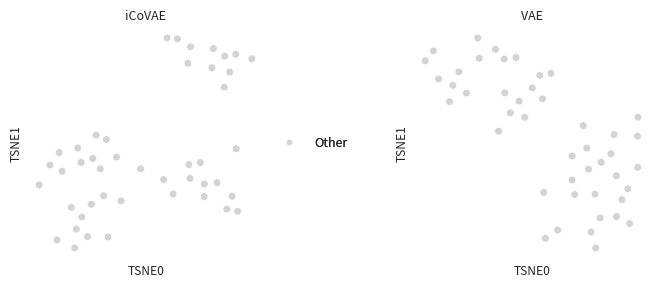

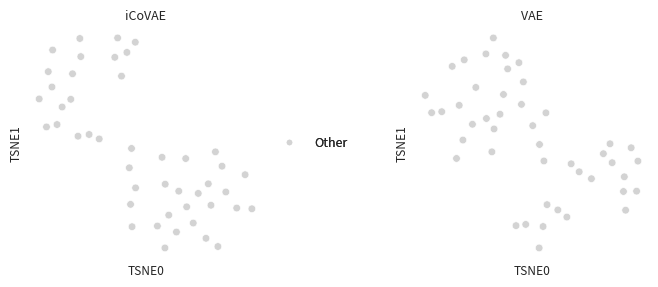

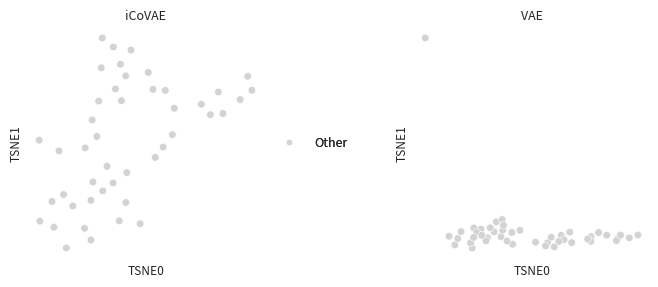

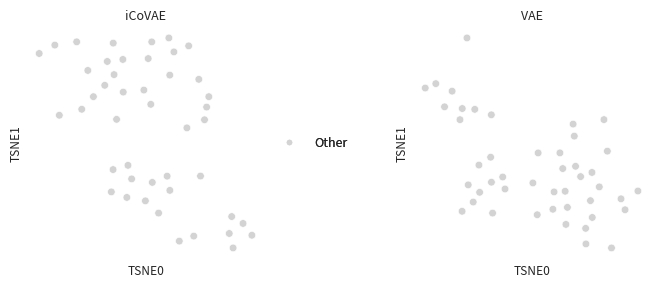

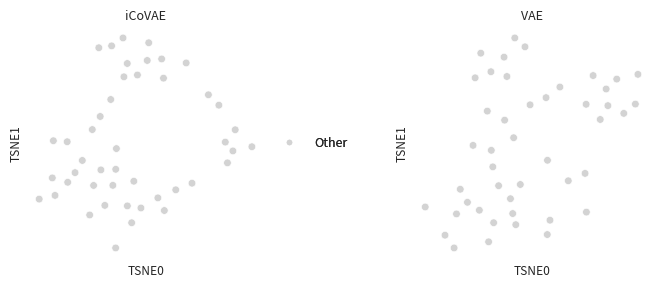

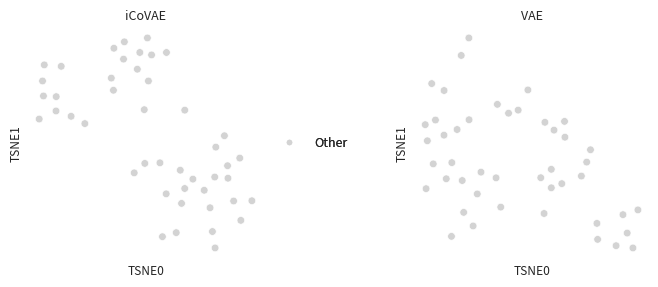

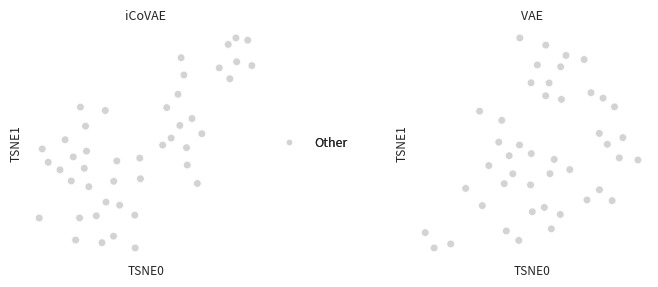

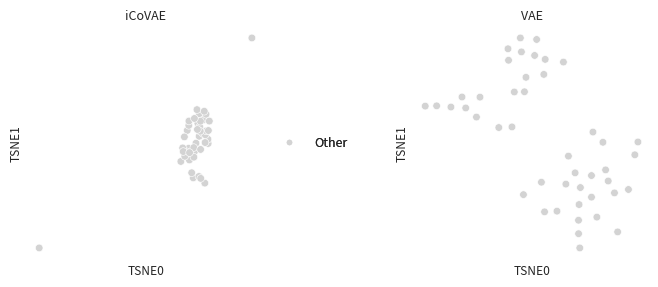

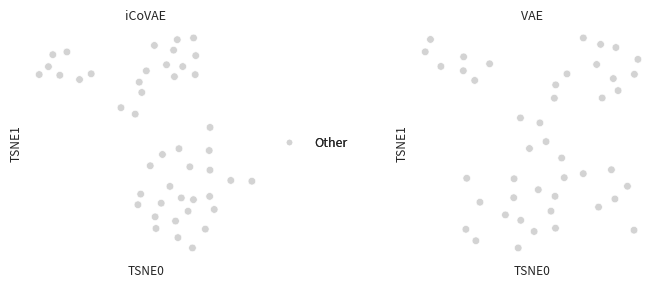

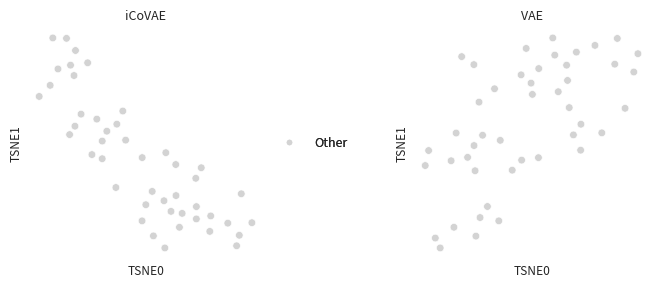

In [ ]:
## PLOT REPRESENTATIONS PCA

from matplotlib.lines import Line2D
import json
from copy import deepcopy

rep_type = "TSNE"
drugs = ["AZD6738", "LAPATINIB", "PALBOCICLIB"]
expi_type = "Breast"
color_genes = ["ATR", "EGFR", "ERBB2"]
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Load representations for each drug
p_list = []
eff_pred_list = []
for drug in drugs:
    print(drug)
    ccvae_folder = f"{wd_path}/data/outputs/{dataset_name}/{drug.upper()}/{expi_type}/pico/ElasticNet_icovae"
    vae_folder = f"{wd_path}/data/outputs/{dataset_name}/{drug.upper()}/{expi_type}/pico/ElasticNet_vae"
    with open(f"{ccvae_folder}/args_best_s10.txt") as f:
        args = json.load(f)
    with open(f"{vae_folder}/args_best_s10.txt") as f:
        vae_args = json.load(f)

    genes = args["constraints"]
    genes = [gene.strip() for gene in genes]

    print(" ".join(genes))
    n_genes = len(genes)
    dataset = Manual(
        x=x, s=s, y=y, constraints=genes, target=drug, params=dataset_params
    )

    for seed in seeds:
        # Consider constrained part of CCVAE and unconstrained separately
        ccvae_test_z = pd.read_csv(f"{ccvae_folder}/z_pred_test_s{seed}.csv")
        ccvae_train_z = pd.read_csv(f"{ccvae_folder}/z_pred_train_s{seed}.csv")

        # Consider whole VAE rep
        vae_test_z = pd.read_csv(f"{vae_folder}/z_pred_test_s{seed}.csv")
        vae_train_z = pd.read_csv(f"{vae_folder}/z_pred_train_s{seed}.csv")

        ccvae_test_z["ModelID"] = ccvae_test_z["ind"].apply(
            lambda x: dataset.idx_to_sample[x]
        )
        vae_test_z["ModelID"] = ccvae_test_z["ind"].apply(
            lambda x: dataset.idx_to_sample[x]
        )
        ccvae_train_z["ModelID"] = ccvae_train_z["ind"].apply(
            lambda x: dataset.idx_to_sample[x]
        )
        vae_train_z["ModelID"] = ccvae_train_z["ind"].apply(
            lambda x: dataset.idx_to_sample[x]
        )

        ccvae_test_z = ccvae_test_z.set_index("ModelID")
        vae_test_z = vae_test_z.set_index("ModelID")
        ccvae_train_z = ccvae_train_z.set_index("ModelID")
        vae_train_z = vae_train_z.set_index("ModelID")

        # Add type info
        ccvae_test_z = pd.merge(
            ccvae_test_z,
            model[["OncotreeLineage", "LegacySubSubtype"]],
            left_index=True,
            right_index=True,
            how="left",
        )
        vae_test_z = pd.merge(
            vae_test_z,
            model[["OncotreeLineage", "LegacySubSubtype"]],
            left_index=True,
            right_index=True,
            how="left",
        )

        ccvae_train_z = pd.merge(
            ccvae_train_z,
            model[["OncotreeLineage", "LegacySubSubtype"]],
            left_index=True,
            right_index=True,
            how="left",
        )
        vae_train_z = pd.merge(
            vae_train_z,
            model[["OncotreeLineage", "LegacySubSubtype"]],
            left_index=True,
            right_index=True,
            how="left",
        )

        s_copy = deepcopy(dataset.s)
        s_df = pd.DataFrame(s_copy, columns=dataset.s_features).reset_index()
        s_df = s_df.rename(lambda x: dataset.idx_to_sample[x], axis=0)

        # Add dependency info if we have it
        ccvae_test_z = pd.merge(
            ccvae_test_z,
            s_df,
            left_index=True,
            right_index=True,
            how="left",
        )
        vae_test_z = pd.merge(
            vae_test_z,
            s_df,
            left_index=True,
            right_index=True,
            how="left",
        )

        ccvae_train_z = pd.merge(
            ccvae_train_z,
            s_df,
            left_index=True,
            right_index=True,
            how="left",
        )
        vae_train_z = pd.merge(
            vae_train_z,
            s_df,
            left_index=True,
            right_index=True,
            how="left",
        )

        # Add mutation info if we have it
        # genes_mut = [gene for gene in genes if gene in mut_df.columns]
        # if len(genes_mut) > 0:
        #     ccvae_test_z = pd.merge(ccvae_test_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)
        #     vae_test_z = pd.merge(vae_test_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)

        # ccvae_train_z = pd.merge(ccvae_train_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)
        # vae_train_z = pd.merge(vae_train_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)

        # Get rep
        ccvae_test_z_rep = ccvae_test_z.iloc[
            :, ccvae_test_z.columns.str.startswith("z")
        ]
        ccvae_test_z_rep = ccvae_test_z_rep.rename(
            mapper=partial(rep_renamer, genes=genes), axis=1
        )

        ccvae_train_z_rep = ccvae_train_z.iloc[
            :, ccvae_train_z.columns.str.startswith("z")
        ]
        ccvae_train_z_rep = ccvae_train_z_rep.rename(
            mapper=partial(rep_renamer, genes=genes), axis=1
        )

        cons_cols = [f"z_{gene}" for gene in genes]

        ccvae_test_z_rep_c = ccvae_test_z_rep.iloc[
            :, ccvae_test_z_rep.columns.isin(cons_cols)
        ]
        ccvae_test_z_rep = ccvae_test_z_rep.iloc[
            :, ~ccvae_test_z_rep.columns.isin(cons_cols)
        ]

        ccvae_train_z_rep_c = ccvae_train_z_rep.iloc[
            :, ccvae_train_z_rep.columns.isin(cons_cols)
        ]
        ccvae_train_z_rep = ccvae_train_z_rep.iloc[
            :, ~ccvae_train_z_rep.columns.isin(cons_cols)
        ]

        vae_test_z_rep = vae_test_z.iloc[:, vae_test_z.columns.str.startswith("z")]
        vae_train_z_rep = vae_train_z.iloc[:, vae_train_z.columns.str.startswith("z")]

        if rep_type == "TSNE":
            ccvae_tsne_c_train = TSNE(n_components=2, perplexity=10).fit_transform(
                ccvae_train_z_rep_c
            )
            ccvae_tsne_train = TSNE(n_components=2, perplexity=10).fit_transform(
                ccvae_train_z_rep
            )
            vae_tsne_train = TSNE(n_components=2, perplexity=10).fit_transform(
                vae_train_z_rep
            )

            ccvae_tsne_c = TSNE(n_components=2, perplexity=10).fit_transform(
                ccvae_test_z_rep_c
            )
            ccvae_tsne = TSNE(n_components=2, perplexity=10).fit_transform(
                ccvae_test_z_rep
            )
            vae_tsne = TSNE(n_components=2, perplexity=10).fit_transform(vae_test_z_rep)

            ccvae_train_rep_c = pd.DataFrame(
                ccvae_tsne_c_train,
                columns=["TSNE0", "TSNE1"],
                index=ccvae_train_z_rep_c.index,
            )
            ccvae_train_rep = pd.DataFrame(
                ccvae_tsne_train,
                columns=["TSNE0", "TSNE1"],
                index=ccvae_train_z_rep.index,
            )
            vae_train_rep = pd.DataFrame(
                vae_tsne_train,
                columns=["TSNE0", "TSNE1"],
                index=vae_train_z_rep.index,
            )

            ccvae_test_rep_c = pd.DataFrame(
                ccvae_tsne_c,
                columns=["TSNE0", "TSNE1"],
                index=ccvae_test_z_rep_c.index,
            )
            ccvae_test_rep = pd.DataFrame(
                ccvae_tsne,
                columns=["TSNE0", "TSNE1"],
                index=ccvae_test_z_rep.index,
            )
            vae_test_rep = pd.DataFrame(
                vae_tsne,
                columns=["TSNE0", "TSNE1"],
                index=vae_test_z_rep.index,
            )

            x_lab = "TSNE0"
            y_lab = "TSNE1"

        elif rep_type == "PCA":
            ccvae_tsne_c = PCA(n_components=4).fit(ccvae_train_z_rep_c)
            ccvae_tsne = PCA(n_components=4).fit(ccvae_train_z_rep)
            vae_tsne = PCA(n_components=4).fit(vae_train_z_rep)

            ccvae_train_rep_c = pd.DataFrame(
                ccvae_tsne_c.transform(ccvae_train_z_rep_c),
                columns=["PC1", "PC2", "PC3", "PC4"],
                index=ccvae_train_z_rep_c.index,
            )
            ccvae_train_rep = pd.DataFrame(
                ccvae_tsne.transform(ccvae_train_z_rep),
                columns=["PC1", "PC2", "PC3", "PC4"],
                index=ccvae_train_z_rep.index,
            )
            vae_train_rep = pd.DataFrame(
                vae_tsne.transform(vae_train_z_rep),
                columns=["PC1", "PC2", "PC3", "PC4"],
                index=vae_train_z_rep.index,
            )

            ccvae_test_rep_c = pd.DataFrame(
                ccvae_tsne_c.transform(ccvae_test_z_rep_c),
                columns=["PC1", "PC2", "PC3", "PC4"],
                index=ccvae_test_z_rep_c.index,
            )
            ccvae_test_rep = pd.DataFrame(
                ccvae_tsne.transform(ccvae_test_z_rep),
                columns=["PC1", "PC2", "PC3", "PC4"],
                index=ccvae_test_z_rep.index,
            )
            vae_test_rep = pd.DataFrame(
                vae_tsne.transform(vae_test_z_rep),
                columns=["PC1", "PC2", "PC3", "PC4"],
                index=vae_test_z_rep.index,
            )

            x_lab = "PC1"
            y_lab = "PC2"
            y_lab2 = "PC3"
            y_lab3 = "PC4"

        ccvae_test_z_c = pd.concat([ccvae_test_z, ccvae_test_rep_c], axis=1)
        ccvae_test_z = pd.concat([ccvae_test_z, ccvae_test_rep], axis=1)
        vae_test_z = pd.concat([vae_test_z, vae_test_rep], axis=1)
        ccvae_test_z_c["set"] = "test"
        ccvae_test_z["set"] = "test"
        vae_test_z["set"] = "test"

        ccvae_train_z_c = pd.concat([ccvae_train_z, ccvae_train_rep_c], axis=1)
        ccvae_train_z = pd.concat([ccvae_train_z, ccvae_train_rep], axis=1)
        vae_train_z = pd.concat([vae_train_z, vae_train_rep], axis=1)
        ccvae_train_z_c["set"] = "train"
        ccvae_train_z["set"] = "train"
        vae_train_z["set"] = "train"

        ccvae_z_c = pd.concat([ccvae_test_z_c, ccvae_train_z_c], axis=0)
        ccvae_z = pd.concat([ccvae_test_z, ccvae_train_z], axis=0)
        vae_z = pd.concat([vae_test_z, vae_train_z], axis=0)

        # Create sequential palettes
        pal0 = sns.light_palette(pal[0], as_cmap=True, reverse=True)
        pal1 = sns.light_palette(pal[1], as_cmap=True, reverse=True)
        pal2 = sns.light_palette(pal[2], as_cmap=True, reverse=True)

        pal_point = sns.color_palette("colorblind", n_colors=3).as_hex()

        bar_pal = {gene: "#888888" for gene in genes if gene not in color_genes}
        for i, gene in enumerate(color_genes):
            bar_pal[gene] = pal_point[i]

        # KO PREDICTION SCATTERPLOTS
        ccvae_z_c_plot = ccvae_test_z_c.drop("LegacySubSubtype", axis=1).dropna(axis=0)
        ccvae_z_plot = ccvae_test_z.drop("LegacySubSubtype", axis=1).dropna(axis=0)
        vae_z_plot = vae_test_z.drop("LegacySubSubtype", axis=1).dropna(axis=0)
        # f_sc, ax_sc = plt.subplots(1,3, figsize=(9,3))
        for i, gene in enumerate(genes):
            # sns.scatterplot(ccvae_z_c_plot, x=f"z_{i}", y=genes[i], hue="OncotreeLineage", style="set", ax=axes_1[i], size=10, markers=["D", "o"], legend=False)
            r_p, _ = pearsonr(ccvae_z_c_plot[f"z_{i}"], ccvae_z_c_plot[f"{gene}_s"])
            r_s, _ = spearmanr(ccvae_z_c_plot[f"z_{i}"], ccvae_z_c_plot[f"{gene}_s"])
            eff_pred_list.append(
                {
                    "gene": gene,
                    "pearson_r": r_p,
                    "spearman_r": r_s,
                    "seed": seed,
                    "drug": drug,
                }
            )

        ccvae_z_c_plot_rep = ccvae_test_z_c.drop(
            ["LegacySubSubtype"] + [f"{gene}_s" for gene in genes], axis=1
        ).dropna(axis=0)
        ccvae_z_plot_rep = ccvae_test_z.drop(
            ["LegacySubSubtype"] + [f"{gene}_s" for gene in genes], axis=1
        ).dropna(axis=0)
        vae_z_plot_rep = vae_test_z.drop(
            ["LegacySubSubtype"] + [f"{gene}_s" for gene in genes], axis=1
        ).dropna(axis=0)

        print(len(ccvae_z_plot_rep))

        pal = sns.color_palette("colorblind")
        all_lineages = ccvae_z_plot_rep["OncotreeLineage"].unique()
        col_lineages = [
            "Bone",
            "Peripheral Nervous System",
            "Liver",
            "Cervix",
            "Kidney",
            "Bladder/Urinary Tract",
            "Fibroblast",
            "Uterus",
            "Pleura",
            "Thyroid",
        ]
        lineage_labels = {
            "Bone": "Bone",
            "Peripheral Nervous System": "PNS",
            "Liver": "Liver",
            "Cervix": "Cervix",
            "Kidney": "Kidney",
            "Bladder/Urinary Tract": "Bladder/UT",
            "Fibroblast": "Fibroblast",
            "Uterus": "Uterus",
            "Pleura": "Pleura",
            "Thyroid": "Thyroid",
        }
        pal_reps = {}
        for lin in all_lineages:
            if lin in col_lineages:
                pal_reps[lin] = pal[col_lineages.index(lin)]
            else:
                pal_reps[lin] = "lightgrey"

        # PCS VS LINEAGE AND DRUG RESPONSE
        fig_1, axes_1 = plt.subplots(1, 2, figsize=(8, 3))
        sns.scatterplot(
            data=ccvae_z_plot_rep,
            x=x_lab,
            y=y_lab,
            hue="OncotreeLineage",
            palette=pal_reps,
            s=30,
            ax=axes_1[0],
            markers=["o", "D"],
            legend=False,
            **{"alpha": 1},
        )
        axes_1[0].set_xticks([])
        axes_1[0].set_yticks([])
        axes_1[0].set_xlabel(x_lab)
        axes_1[0].set_ylabel(y_lab)
        axes_1[0].set_title("iCoVAE", fontweight="regular", fontsize=10)
        sns.despine(left=True, bottom=True, ax=axes_1[0])
        sns.scatterplot(
            data=vae_z_plot_rep,
            x=x_lab,
            y=y_lab,
            hue="OncotreeLineage",
            palette=pal_reps,
            s=30,
            ax=axes_1[1],
            markers=["o", "D"],
            legend="brief",
            **{"alpha": 1},
        )
        axes_1[1].set_xticks([])
        axes_1[1].set_yticks([])
        axes_1[1].set_xlabel(x_lab)
        axes_1[1].set_ylabel(y_lab)
        axes_1[1].set_title("VAE", fontweight="regular", fontsize=10)
        sns.despine(left=True, bottom=True, ax=axes_1[1])
        axes_1[1].get_legend().remove()

        handles = []
        labels = []
        for lin, col in pal_reps.items():
            if lin in col_lineages:
                handles.append(
                    Line2D(
                        [0],
                        [0],
                        label=lineage_labels[lin],
                        marker="o",
                        markersize=4,
                        markeredgecolor="none",
                        markerfacecolor=col,
                        linestyle="",
                    )
                )

        handles.append(
            Line2D(
                [0],
                [0],
                label="Other",
                marker="o",
                markersize=4,
                markeredgecolor="none",
                markerfacecolor="lightgrey",
                linestyle="",
            )
        )

        plt.subplots_adjust(wspace=0.65)

        leg1 = axes_1[0].legend(
            handles=handles,
            bbox_to_anchor=(1, 0.5),
            loc="center left",
            frameon=False,
            ncol=1,
            fontsize=10,
        )

        axes_1[0].add_artist(leg1)

        fig_1.savefig(
            f"{wd_path}/results_analysis/figures/{dataset_name}_rep_{drug}_{expi_type}_{seed}.png",
            dpi=600,
            bbox_extra_artists=(leg1,),
        )
        fig_1.savefig(
            f"{wd_path}/results_analysis/figures/{dataset_name}_rep_{drug}_{expi_type}_{seed}.svg",
            bbox_extra_artists=(leg1,),
        )

KeyError: 'Breast'

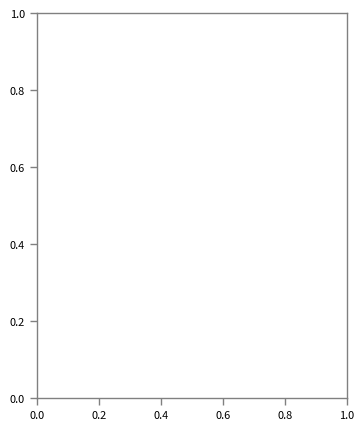

In [23]:
# LINEAGES HISTPLOT - THIS WILL BE FOR THE FINAL SEED
f, ax = plt.subplots(1, 1, figsize=(4, 5))
ccvae_z_summ = ccvae_z.copy()
ccvae_z_summ["OncotreeLineage"] = ccvae_z_summ["OncotreeLineage"].map(
    lambda x: lineage_labels[x]
)
sns.histplot(
    data=ccvae_z_summ,
    y="OncotreeLineage",
    hue="set",
    ax=ax,
    hue_order=["train", "test"],
)
sns.despine()
sns.move_legend(
    ax, loc="upper center", frameon=False, ncol=2, title="", bbox_to_anchor=(0.5, 1.05)
)
ax.set_xlabel("Count")
ax.set_ylabel("")
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_h16_lineages.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_h16_lineages.png",
    bbox_inches="tight",
    dpi=600,
)

### 1.1.2 Prediction of gene effect

                      pearson_r  spearman_r  seed
drug        gene                                 
AZD6738     CCL16      0.205139    0.213498  55.0
            CNN2       0.415721    0.417340  55.0
            H2AZ1     -0.039126   -0.019310  55.0
            HUS1       0.103844    0.108276  55.0
            POMP       0.178562    0.193005  55.0
            POP5       0.334541    0.368473  55.0
            PSMA2      0.122419    0.098325  55.0
            PSMC4     -0.330051   -0.134680  55.0
            PTPMT1     0.230995    0.238473  55.0
            RAD1       0.136314    0.129064  55.0
            RAD17     -0.047655   -0.051133  55.0
            RAD9A      0.103007    0.132808  55.0
            RNASEH2C   0.290102    0.316749  55.0
            TFIP11     0.289064    0.287094  55.0
            VCP        0.209550    0.206010  55.0
            ZNF830    -0.015854   -0.017980  55.0
LAPATINIB   BIRC6      0.318285    0.387192  55.0
            CAP1       0.186654    0.278916  55.0


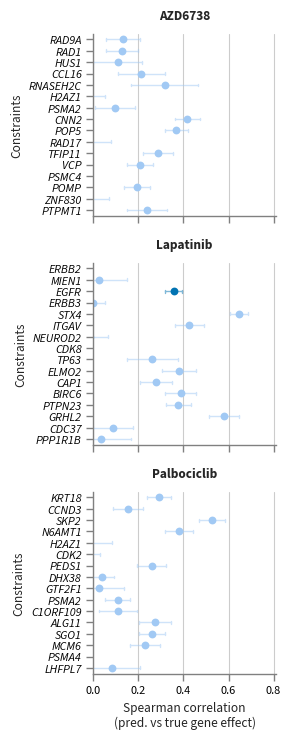

In [24]:
gene_corr_df = pd.DataFrame(eff_pred_list)
print(gene_corr_df.groupby(["drug", "gene"]).mean())

drugs_plot = ["AZD6738", "LAPATINIB", "PALBOCICLIB"]
gene_corr_df = gene_corr_df[gene_corr_df["drug"].isin(drugs_plot)]
# KO PREDICTION BARPLOT
pal_point = sns.color_palette("colorblind", n_colors=3).as_hex()
pal_light = sns.color_palette("pastel", n_colors=3).as_hex()
drug_target = ["ATR", "EGFR", "ERBB2", "CDK4", "CDK6"]
bar_pal = {
    gene: pal_light[0]
    for gene in gene_corr_df["gene"].unique()
    if gene not in drug_target
}

for i, gene in enumerate(drug_target):
    bar_pal[gene] = pal_point[0]

yticks = sorted(gene_corr_df["gene"].unique())
g = sns.catplot(
    data=gene_corr_df,
    kind="point",
    sharey=False,
    row="drug",
    x="spearman_r",
    y="gene",
    hue="gene",
    row_order=drugs_plot,
    linestyle="none",
    height=2.5,
    capsize=0.25,
    palette=bar_pal,
    errorbar=("sd", 1),
    aspect=1.2,
    legend=None,
    err_kws={"linewidth": 1, "alpha": 0.5},
    markersize=4,
)

axes = g.axes.flatten()
for i, ax in enumerate(axes):
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8], [0.0, 0.2, 0.4, 0.6, 0.8])
    ax.set_xlim(0, 0.81)
    ax.set_ylabel("Constraints")
    ax.set_xlabel("Spearman correlation\n(pred. vs true gene effect)")
    ax.set_title("")
    if drugs_plot[i] in ["AZD5991", "AZD6738"]:
        ax.text(
            s=f"{drugs_plot[i]}",
            x=0.5,
            y=1.1,
            weight="bold",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            rotation=0,
        )
    else:
        ax.text(
            s=f"{drugs_plot[i].capitalize()}",
            x=0.5,
            y=1.1,
            weight="bold",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            rotation=0,
        )
    labels = ax.get_yticklabels()
    for lbl in labels:
        lbl.set_style("italic")
    sns.despine(ax=ax)
    ax.grid(visible=True, axis="x")
plt.tight_layout()


g.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_eff_pred_multi_{expi_type}.png",
    dpi=600,
    bbox_inches="tight",
)
g.savefig(
    f"{wd_path}/results_analysis/figures/{dataset_name}_eff_pred_multi_{expi_type}.svg",
    bbox_inches="tight",
)

## 1.2 Constraint analysis

In [4]:
## 1.2 Constraint analysis
drugs = [
    "Docetaxel",
    "AZD5991",
    "Paclitaxel",
    "Sorafenib",
    "Alpelisib",
    "Gefitinib",
    "AZD8186",
    "Lapatinib",
    "AZD3759",
    "Palbociclib",
    "Taselisib",
    "Lapatinib",
    "Afatinib",
    "Afuresertib",
    "Serdemetan",
    "Oxaliplatin",
    "GSK1904529A",
    "Buparlisib",
    "Linsitinib",
    "Ipatasertib",
    "Sabutoclax",
    "Ribociclib",
    "MK-8776",
    "Cisplatin",
    "Osimertinib",
    "Erlotinib",
    "AZD6738",
    "Niraparib",
    "Veliparib",
    "Olaparib",
    "MK-1775",
    "Epirubicin",
    "Cyclophosphamide",
    "Methotrexate",
    "Venetoclax",
    "AZD5153",
    "JQ1",
    "PD173074",
    "Sapitinib",
    "Tamoxifen",
    "AZD4547",
    "Vorinostat",
    "Refametinib",
    "Selumetinib",
    "Trametinib",
    "Axitinib",
    "GSK2830371A",
    "CCT007093",
    "Gemcitabine",
    "VE-822",
]

target_dict = {
    "AZD5991": "MCL1/BCL2",
    "Alpelisib": "PI3K",
    "AZD8186": "PI3K",
    "Gefitinib": "EGFR/ERBB2",
    "Lapatinib": "EGFR/ERBB2",
    "Sorafenib": "VEGFR",
    "Docetaxel": "Taxane",
    "Paclitaxel": "Taxane",
    "Taselisib": "PI3K",
    "Palbociclib": "CDK4/6",
    "AZD3759": "EGFR/ERBB2",
    "Afatinib": "EGFR/ERBB2",
    "Afuresertib": "AKT",
    "Serdemetan": "MDM2",
    "Oxaliplatin": "Platinum",
    "GSK1904529A": "IGF1R",
    "Buparlisib": "PI3K",
    "Linsitinib": "IGF1R",
    "Ipatasertib": "AKT",
    "CZC24832": "PI3K",
    "Sabutoclax": "MCL1/BCL2",
    "MK-8776": "CHEK1",
    "Ribociclib": "CDK4/6",
    "Cisplatin": "Platinum",
    "Osimertinib": "EGFR/ERBB2",
    "Erlotinib": "EGFR/ERBB2",
    "AZD6738": "ATR",
    "Olaparib": "PARP",
    "Niraparib": "PARP",
    "Veliparib": "PARP",
    "MK-1775": "WEE1",
    "Cyclophosphamide": "Alkylating agent",
    "5-Fluorouracil": "Antimetabolite",
    "Epirubicin": "Anthracycline",
    "Tamoxifen": "ER",
    "Methotrexate": "Antimetabolite",
    "Venetoclax": "MCL1/BCL2",
    "AZD5153": "BRD4",
    "JQ1": "BRD4",
    "PD173074": "FGFR",
    "Saptinib": "EGFR/ERBB2",
    "AZD4547": "FGFR",
    "Vorinostat": "HDAC",
    "Refametinib": "MEK",
    "Selumetinib": "MEK",
    "Trametinib": "MEK",
    "Axitinib": "VEGFR",
    "GSK2830371A": "PPM1D",
    "CCT007093": "PPM1D",
    "Gemcitabine": "Antimetabolite",
    "Irinotecan": "TOP1",
    "VE-822": "ATR",
}

constraints_list = []
for drug in drugs:
    try:
        try:
            curr_constraints = pd.read_csv(
                f"{wd_path}/data/constraints/univar_lm_{drug.upper()}_lrt_IC50_depmap_gdsc_h16_v2.csv"
            )
        except:
            curr_constraints = pd.read_csv(
                f"{wd_path}/data/constraints/univar_lm_{drug.upper()}_lrt_IC50_GDSC_h16_v2.csv"
            )
        curr_constraints = curr_constraints[curr_constraints["p_corrected"] < 0.05]
        # Top 32 constraints
        curr_constraints = curr_constraints.sort_values(
            "p_corrected", ascending=True
        ).head(32)
        for i, row in curr_constraints.iterrows():
            constraints_list.append(
                {
                    "drug": drug,
                    "target": target_dict[drug],
                    "gene": row["gene"],
                    "p_corrected": row["p_corrected"],
                }
            )
    except:
        print(f"{drug} not found")
        continue

constraints_df = pd.DataFrame.from_dict(constraints_list)

MK-8776 not found
MK-1775 not found
Sapitinib not found


/home/dk538/.conda/envs/slurm-torch-2/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


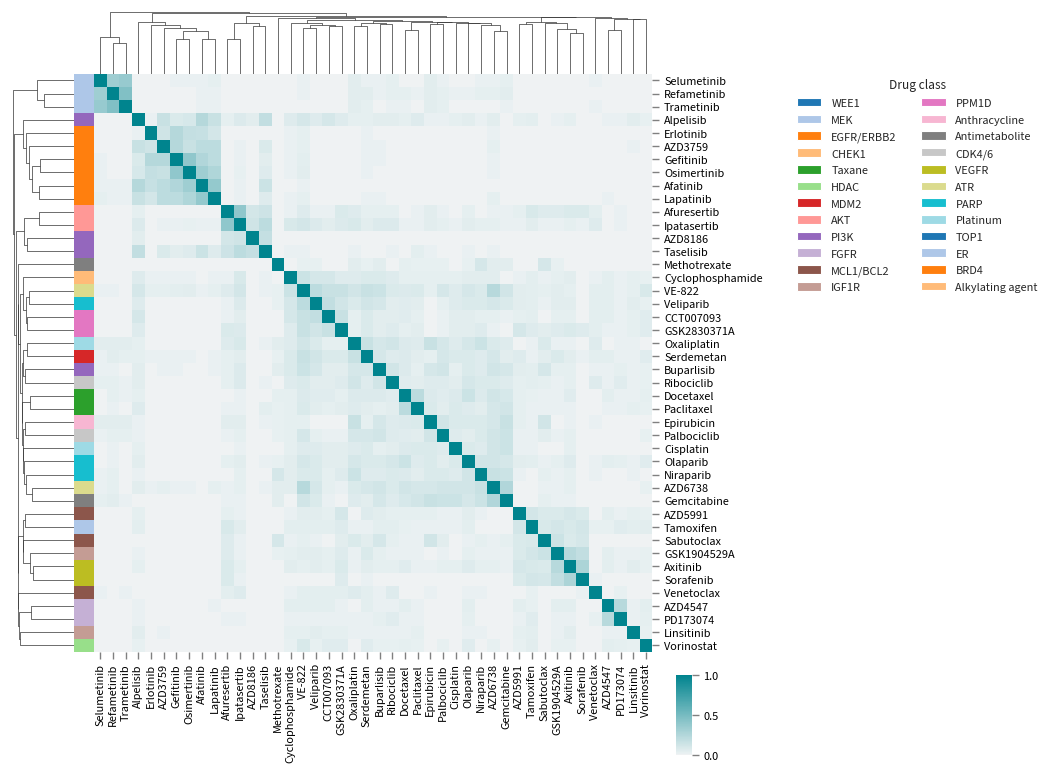

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.colors import rgb_to_hsv
from matplotlib.patches import Patch

constraints_mat = constraints_df.pivot_table(
    values="p_corrected", columns="gene", index="drug", fill_value=1
)
constraints_mat_int = (constraints_mat < 0.05).astype(int)

constraint_sim = 1 - pairwise_distances(
    constraints_mat_int.to_numpy(), metric="jaccard"
)
constraint_sim = pd.DataFrame(
    constraint_sim, index=constraints_mat.index, columns=constraints_mat.index
)

constraint_targets = [target_dict[drug] for drug in constraint_sim.index]

pal = sns.color_palette("tab20")

# pal = sns.color_palette("mako", 24)
# sns.palplot(custom_palette)

pal_cm = sns.diverging_palette(
    rgb_to_hsv(pal[1])[0] * 360,
    rgb_to_hsv(pal[0])[0] * 360,
    s=100,
    center="light",
    as_cmap=True,
)

col_colors_pal = {
    target: pal[i % 20] for i, target in enumerate(list(set(target_dict.values())))
}

col_colors = [col_colors_pal[target] for target in constraint_targets]
# col_colors = pd.Series(data=col_colors, name="Target")
# print(col_colors)

# fig, ax = plt.subplots(1,1, figsize=(6,6))
g = sns.clustermap(
    data=constraint_sim,
    xticklabels=True,
    yticklabels=True,
    cmap=pal_cm,
    row_colors=col_colors,
    figsize=(8, 8),
    dendrogram_ratio=0.1,
    cbar_pos=(0.85, 0.05, 0.02, 0.1),
    center=0.0,
)
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

# Add legend for row colors
legend_patches = [
    Patch(facecolor=color, label=label) for label, color in col_colors_pal.items()
]
g.ax_heatmap.legend(
    handles=legend_patches,
    title="Drug class",
    loc="upper left",
    bbox_to_anchor=(1.25, 1.0),
    borderaxespad=0.0,
    frameon=False,
    ncol=2,
)

plt.savefig(
    f"{wd_path}/results_analysis/figures/constraints/constraint_jacc_heatmap.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/constraints/constraint_jacc_heatmap.png",
    dpi=1200,
    bbox_inches="tight",
)

        gene  drug  target  p_corrected
0       MCL1    20      20           20
1      PSMA2    18      18           18
2       POP5    13      13           13
3      COPB2    12      12           12
4        VCP    12      12           12
5   C1ORF109    11      11           11
6      ITGB5    10      10           10
7   RNASEH2C    10      10           10
8       GBF1     9       9            9
9       CAP1     9       9            9
10     ITGAV     9       9            9
11   MARCHF5     8       8            8
12    BORCS8     8       8            8
13     TEAD1     8       8            8
14     ERBB2     8       8            8
15   METTL17     8       8            8
16      TSFM     8       8            8
17     PSMA6     7       7            7
18      EGFR     7       7            7
19      NMT1     7       7            7
20     COX11     7       7            7
21     MAPK1     6       6            6
22      TFAM     6       6            6
23     PSMC1     6       6            6


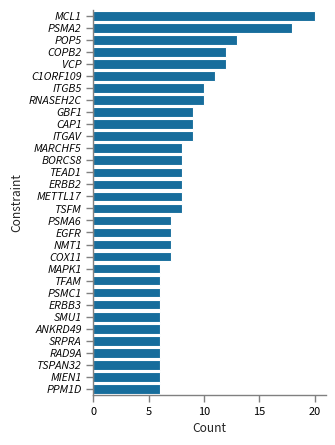

In [6]:
constraint_counts = (
    constraints_df.groupby("gene")
    .count()
    .sort_values("drug", ascending=False)
    .head(32)
    .reset_index()
)
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
print(constraint_counts)

sns.barplot(data=constraint_counts, y="gene", x="p_corrected", ax=ax)
ax.set_xlabel("Count")
ax.set_ylabel("Constraint")
labels = ax.get_yticklabels()

for lbl in labels:
    lbl.set_style("italic")

sns.despine(ax=ax)

plt.savefig(
    f"{wd_path}/results_analysis/figures/constraints/constraint_count.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/constraints/constraint_count.png",
    dpi=1200,
    bbox_inches="tight",
)

In [7]:
# Most common constraints -- general constraint set?
constraints_df.groupby("gene").count().sort_values("drug", ascending=False).head(
    32
).index.tolist()

['MCL1',
 'PSMA2',
 'POP5',
 'COPB2',
 'VCP',
 'C1ORF109',
 'ITGB5',
 'RNASEH2C',
 'GBF1',
 'CAP1',
 'ITGAV',
 'MARCHF5',
 'BORCS8',
 'TEAD1',
 'ERBB2',
 'METTL17',
 'TSFM',
 'PSMA6',
 'EGFR',
 'NMT1',
 'COX11',
 'MAPK1',
 'TFAM',
 'PSMC1',
 'ERBB3',
 'SMU1',
 'ANKRD49',
 'SRPRA',
 'RAD9A',
 'TSPAN32',
 'MIEN1',
 'PPM1D']

In [6]:
# KO PREDICTABILITY
import json
from copy import deepcopy

model = pd.read_csv(f"{wd_path}/data/depmap23q2/Model.csv")

model["OncotreeLineage"] = model["OncotreeLineage"].map(type_renamer)

model = model.set_index("ModelID")

dataset_name = "depmap_gdsc"
expi_type = "h16"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# PROCESS DATASET
x, s, c, y, test_samples = process_data(
    dataset=dataset_name, wd_path=wd_path, experiment=expi_type
)

dataset_params = {"var_filt_x": 1, "var_filt_s": None}

eff_pred_list = []
for drug in drugs:
    print(drug)
    try:
        # ccvae_folder = f"R:/graphdep/data/outputs/ElasticNet_{drug.upper()}_s{seed}_ccvae_{drug.upper()}_{dataset}_{target}_s{seed}_{expi_type}"
        # vae_folder = f"R:/graphdep/data/outputs/ElasticNet_{drug.upper()}_s{seed}_vae_{dataset}_{target}_s{seed}_{expi_type}"
        ccvae_folder = f"{wd_path}/data/outputs/{dataset_name}/{drug.upper()}/{expi_type}/pico/ElasticNet_icovae"
        vae_folder = f"{wd_path}/data/outputs/{dataset_name}/{drug.upper()}/{expi_type}/pico/ElasticNet_vae"
        with open(f"{ccvae_folder}/args_best.txt") as f:
            args = json.load(f)
        # with torch.no_grad():
        #     reg_model = torch.load(f"{ccvae_folder}/regressor_s{seed}.pt", map_location=torch.device("cpu"))
        #     print(reg_model)
        #     reg_weights = reg_model.reg.mean_coeff.numpy()
        #     reg_bias = reg_model.reg.mean_bias.numpy()
        # print(reg_weights)
        # print(reg_bias)

        # resp = resp.dropna(axis=0).reset_index(drop=True)
        # zdim = args["zdim"]
        # vae_zdim = vae_args["zdim"]
        genes = args["constraints"]
        # genes = ast.literal_eval(genes)
        genes = [gene.strip() for gene in genes]

        print(" ".join(genes))
        n_genes = len(genes)
        dataset = Manual(
            x=x, s=s, y=y, constraints=genes, target=drug, params=dataset_params
        )

        for seed in seeds:
            # Consider constrained part of CCVAE and unconstrained separately
            ccvae_test_z = pd.read_csv(f"{ccvae_folder}/z_pred_test_s{seed}.csv")
            ccvae_train_z = pd.read_csv(f"{ccvae_folder}/z_pred_train_s{seed}.csv")

            ccvae_test_z["ModelID"] = ccvae_test_z["ind"].apply(
                lambda x: dataset.idx_to_sample[x]
            )
            ccvae_train_z["ModelID"] = ccvae_train_z["ind"].apply(
                lambda x: dataset.idx_to_sample[x]
            )

            ccvae_test_z = ccvae_test_z.set_index("ModelID")
            ccvae_train_z = ccvae_train_z.set_index("ModelID")

            # Add type info
            ccvae_test_z = pd.merge(
                ccvae_test_z,
                model[["OncotreeLineage", "LegacySubSubtype"]],
                left_index=True,
                right_index=True,
                how="left",
            )

            ccvae_train_z = pd.merge(
                ccvae_train_z,
                model[["OncotreeLineage", "LegacySubSubtype"]],
                left_index=True,
                right_index=True,
                how="left",
            )

            s_copy = deepcopy(dataset.s)
            s_df = pd.DataFrame(s_copy, columns=dataset.s_features).reset_index()
            s_df = s_df.rename(lambda x: dataset.idx_to_sample[x], axis=0)

            # Add dependency info if we have it
            ccvae_test_z = pd.merge(
                ccvae_test_z,
                s_df,
                left_index=True,
                right_index=True,
                how="left",
            )

            ccvae_train_z = pd.merge(
                ccvae_train_z,
                s_df,
                left_index=True,
                right_index=True,
                how="left",
            )

            # Add mutation info if we have it
            # genes_mut = [gene for gene in genes if gene in mut_df.columns]
            # if len(genes_mut) > 0:
            #     ccvae_test_z = pd.merge(ccvae_test_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)
            #     vae_test_z = pd.merge(vae_test_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)

            # ccvae_train_z = pd.merge(ccvae_train_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)
            # vae_train_z = pd.merge(vae_train_z, mut_df[genes_mut + ["ModelID"]], left_on="ModelID", right_on="ModelID", how="left", suffixes=("", "_mut")).drop("ModelID", axis=1)

            # Get rep
            ccvae_test_z_rep = ccvae_test_z.iloc[
                :, ccvae_test_z.columns.str.startswith("z")
            ]
            ccvae_test_z_rep = ccvae_test_z_rep.rename(
                mapper=partial(rep_renamer, genes=genes), axis=1
            )

            ccvae_train_z_rep = ccvae_train_z.iloc[
                :, ccvae_train_z.columns.str.startswith("z")
            ]
            ccvae_train_z_rep = ccvae_train_z_rep.rename(
                mapper=partial(rep_renamer, genes=genes), axis=1
            )

            cons_cols = [f"z_{gene}" for gene in genes]

            ccvae_test_z_rep_c = ccvae_test_z_rep.iloc[
                :, ccvae_test_z_rep.columns.isin(cons_cols)
            ]
            ccvae_test_z_rep = ccvae_test_z_rep.iloc[
                :, ~ccvae_test_z_rep.columns.isin(cons_cols)
            ]

            ccvae_train_z_rep_c = ccvae_train_z_rep.iloc[
                :, ccvae_train_z_rep.columns.isin(cons_cols)
            ]
            ccvae_train_z_rep = ccvae_train_z_rep.iloc[
                :, ~ccvae_train_z_rep.columns.isin(cons_cols)
            ]

            ccvae_test_z_c = pd.concat([ccvae_test_z], axis=1)
            ccvae_test_z = pd.concat([ccvae_test_z], axis=1)
            ccvae_test_z_c["set"] = "test"
            ccvae_test_z["set"] = "test"

            ccvae_train_z_c = pd.concat([ccvae_train_z], axis=1)
            ccvae_train_z = pd.concat([ccvae_train_z], axis=1)
            ccvae_train_z_c["set"] = "train"
            ccvae_train_z["set"] = "train"

            ccvae_z_c = pd.concat([ccvae_test_z_c, ccvae_train_z_c], axis=0)
            ccvae_z = pd.concat([ccvae_test_z, ccvae_train_z], axis=0)

            # KO PREDICTION SCATTERPLOTS
            ccvae_z_c_plot = ccvae_test_z_c.drop("LegacySubSubtype", axis=1).dropna(
                axis=0
            )
            ccvae_z_plot = ccvae_test_z.drop("LegacySubSubtype", axis=1).dropna(axis=0)
            # f_sc, ax_sc = plt.subplots(1,3, figsize=(9,3))
            for i, gene in enumerate(genes):
                # sns.scatterplot(ccvae_z_c_plot, x=f"z_{i}", y=genes[i], hue="OncotreeLineage", style="set", ax=axes_1[i], size=10, markers=["D", "o"], legend=False)
                r_p, _ = pearsonr(ccvae_z_c_plot[f"z_{i}"], ccvae_z_c_plot[f"{gene}_s"])
                r_s, _ = spearmanr(
                    ccvae_z_c_plot[f"z_{i}"], ccvae_z_c_plot[f"{gene}_s"]
                )
                eff_pred_list.append(
                    {
                        "gene": gene,
                        "pearson_r": r_p,
                        "spearman_r": r_s,
                        "seed": seed,
                        "drug": drug,
                    }
                )
    except:
        print(f"{drug.capitalize()} not found...")

Docetaxel
MCL1 NUP153 GBF1 TSG101 BUB1B PSMA2 CABIN1 RGS17 RNASEH2C BCL2L2 KDM8 OIP5 OR6C1 SRFBP1 ZNF830 PLEK2 PARD6B CDH24 ISY1 KRAS C1ORF109 TXNRD1 TSPAN32 HNF1B H3C4 CHMP4A H3C12 RBBP4 DHRS4 PTPMT1 SNAPC5 GALP
443
242
518
247

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 32)
y                                  (1450, 1)
--------------------------------------------------
AZD5991
MCL1 MARCHF5 UBE2J2 H2AC20 NOA1 TEAD1 ILK METTL17 NELFA SH3GL1 TOMM70 POLR1B EP300 TSFM GSS EFL1
361
173
600
316

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 16)
y       

         gene     value       metric
0        MCL1  0.000000        Count
1       PSMA2  0.000000        Count
2        POP5  0.000000        Count
3       COPB2  0.000000        Count
4         VCP  0.000000        Count
...       ...       ...          ...
1225  METTL17  0.352539  Correlation
1226  METTL17  0.320539  Correlation
1227  METTL17  0.371774  Correlation
1228  METTL17  0.378633  Correlation
1229  METTL17  0.302714  Correlation

[1246 rows x 3 columns]


/tmp/ipykernel_3204127/1393684124.py:37: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(
/tmp/ipykernel_3204127/1393684124.py:43: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(


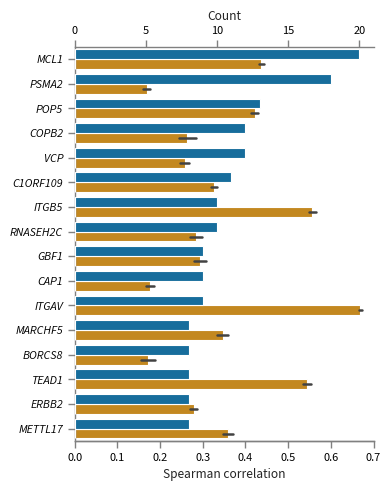

In [9]:
# CONSTRAINT COUNTS AND PREDICTABILITY
pal = sns.color_palette("colorblind")
# Merge data to align by gene
constraint_counts = (
    constraints_df.groupby("gene").count().sort_values("drug", ascending=False).head(16)
)
eff_pred_df = (
    pd.DataFrame.from_dict(eff_pred_list).set_index("gene").loc[constraint_counts.index]
)

# Add "gene" as a column for merging
constraint_counts = constraint_counts.reset_index()
eff_pred_df = eff_pred_df.reset_index()

# Create shared y-axis order
gene_order = constraint_counts["gene"]

# Assign hue labels
constraint_counts["value"] = constraint_counts["p_corrected"]
constraint_counts["metric"] = "Count"
eff_pred_df["value"] = eff_pred_df["spearman_r"]
eff_pred_df["metric"] = "Correlation"

# Keep only needed columns
constraint_plot = constraint_counts[["gene", "value", "metric"]]
correlation_plot = eff_pred_df[["gene", "value", "metric"]]

# Combine
plot_df = pd.concat([constraint_plot, correlation_plot])
plot_df_1 = plot_df.copy()
plot_df_1.loc[plot_df_1["metric"] == "Correlation", "value"] = 0
plot_df.loc[plot_df["metric"] == "Count", "value"] = 0

print(plot_df)

# Initialize figure and axes
fig, ax1 = plt.subplots(figsize=(4, 5))
ax2 = ax1.twiny()

# Plot counts (metric A) on ax1
sns.barplot(
    data=plot_df, x="value", y="gene", hue="metric", dodge=True, ax=ax1, palette=pal
)

# Plot correlations (metric B) on ax2
sns.barplot(
    data=plot_df_1, x="value", y="gene", hue="metric", dodge=True, ax=ax2, palette=pal
)

# Label axes
ax2.set_xlabel("Count")
ax1.set_xlabel("Spearman correlation")
ax1.set_ylabel("")

ax1.set_xlim(0, 0.7)

# Clean legends
ax1.legend([], [], frameon=False)
ax2.legend([], [], frameon=False)

# Italicize y-axis labels
for lbl in ax1.get_yticklabels():
    lbl.set_style("italic")

# Final cleanup
sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True, top=False)
plt.tight_layout()

plt.savefig(
    f"{wd_path}/results_analysis/figures/constraints/constraint_count_pred.svg",
    bbox_inches="tight",
)
plt.savefig(
    f"{wd_path}/results_analysis/figures/constraints/constraint_count_pred.png",
    dpi=1200,
    bbox_inches="tight",
)

In [21]:
# GENERAL CONSTRAINT SET
constraint_counts = (
    constraints_df.groupby("gene").count().sort_values("drug", ascending=False)
)
eff_pred_df = (
    pd.DataFrame.from_dict(eff_pred_list)
    .set_index("gene")
    .drop("drug", axis=1)
    .groupby("gene")
    .mean()
)

gen_con_df = pd.merge(constraint_counts, eff_pred_df, left_index=True, right_index=True)

# TOP 32 CONSTRAINTS
gen_con_df[gen_con_df["spearman_r"] > 0.3][:32].index.tolist()

['MCL1',
 'POP5',
 'C1ORF109',
 'ITGB5',
 'ITGAV',
 'MARCHF5',
 'TEAD1',
 'METTL17',
 'EGFR',
 'NMT1',
 'COX11',
 'TFAM',
 'ANKRD49',
 'RAD9A',
 'PPM1D',
 'RAD1',
 'MRPS16',
 'MRPL4',
 'RICTOR',
 'MDM2',
 'ILK',
 'STX4',
 'PKN2',
 'PGK1',
 'GRB2',
 'MRPL21',
 'MAPKAP1',
 'COX5B',
 'GRHL2',
 'H2AZ1',
 'NOA1',
 'MRPS11']

# 2 Performance comparisons

## 2.1 Prediction performance on DepMap/GDSC experiments

### 2.1.1 Comparison across all drugs

In [5]:
target_dict = {
    "AZD5991": "MCL1/BCL2",
    "Alpelisib": "PI3K",
    "AZD8186": "PI3K",
    "Gefitinib": "EGFR/ERBB2",
    "Lapatinib": "EGFR/ERBB2",
    "Sorafenib": "VEGFR",
    "Docetaxel": "Taxane",
    "Paclitaxel": "Taxane",
    "Taselisib": "PI3K",
    "Palbociclib": "CDK4/6",
    "AZD3759": "EGFR/ERBB2",
    "Afatinib": "EGFR/ERBB2",
    "Afuresertib": "AKT",
    "Serdemetan": "MDM2",
    "Oxaliplatin": "Platinum",
    "GSK1904529A": "IGF1R",
    "Buparlisib": "PI3K",
    "Linsitinib": "IGF1R",
    "Ipatasertib": "AKT",
    "CZC24832": "PI3K",
    "Sabutoclax": "MCL1/BCL2",
    "MK-8776": "CHEK1",
    "Ribociclib": "CDK4/6",
    "Cisplatin": "Platinum",
    "Osimertinib": "EGFR/ERBB2",
    "Erlotinib": "EGFR/ERBB2",
    "AZD6738": "ATR",
    "Olaparib": "PARP",
    "Niraparib": "PARP",
    "Veliparib": "PARP",
    "MK-1775": "WEE1",
    "Cyclophosphamide": "Alkylating agent",
    "5-Fluorouracil": "Antimetabolite",
    "Epirubicin": "Anthracycline",
    "Tamoxifen": "ER",
    "Methotrexate": "Antimetabolite",
    "Venetoclax": "MCL1/BCL2",
    "AZD5153": "BRD4",
    "JQ1": "BRD4",
    "PD173074": "FGFR",
    "Saptinib": "EGFR/ERBB2",
    "AZD4547": "FGFR",
    "Vorinostat": "HDAC",
    "Refametinib": "MEK",
    "Selumetinib": "MEK",
    "Trametinib": "MEK",
    "Axitinib": "VEGFR",
    "GSK2830371A": "PPM1D",
    "CCT007093": "PPM1D",
    "Gemcitabine": "Antimetabolite",
    "Irinotecan": "TOP1",
    "VE-822": "ATR",
}
# FULL DRUG LIST FOR H16
drugs = [
    "Docetaxel",
    "AZD5991",
    "Paclitaxel",
    "Sorafenib",
    "Alpelisib",
    "Gefitinib",
    "AZD8186",
    "Lapatinib",
    "AZD3759",
    "Palbociclib",
    "Taselisib",
    "Lapatinib",
    "Afatinib",
    "Afuresertib",
    "Serdemetan",
    "Oxaliplatin",
    "GSK1904529A",
    "Buparlisib",
    "Linsitinib",
    "Ipatasertib",
    "Sabutoclax",
    "Ribociclib",
    "MK-8776",
    "Cisplatin",
    "Osimertinib",
    "Erlotinib",
    "AZD6738",
    "Niraparib",
    "Veliparib",
    "Olaparib",
    "MK-1775",
    "Epirubicin",
    "Cyclophosphamide",
    "Methotrexate",
    "Venetoclax",
    "AZD5153",
    "JQ1",
    "PD173074",
    "Sapitinib",
    "Tamoxifen",
    "AZD4547",
    "Vorinostat",
    "Refametinib",
    "Selumetinib",
    "Trametinib",
    "Axitinib",
    "GSK2830371A",
    "CCT007093",
    "Gemcitabine",
    "VE-822",
]

# drugs = ["AZD6738"]

# drugs = [drug.upper() for drug in drugs]
# target_dict = {key.upper(): val for key, val in target_dict.items()}


# DRUG LIST FOR BREAST ONLY EXPERIMENTS
# drugs = ["Lapatinib", "Afuresertib", "Epirubicin", "Docetaxel", "Ipatasertib", "Cisplatin", "Oxaliplatin", "AZD6738", "5-Fluorouracil", "Cyclophosphamide",
# "Ribociclib", "Palbociclib", "Niraparib", "Olaparib", "Veliparib", "Alpelisib", "Tamoxifen"]

# DRUG LIST FOR PAPER REPORTING -- BREAST
# drugs = ["Alpelisib", "Oxaliplatin", "Ipatasertib", "Docetaxel", "AZD6738", "Erlotinib", "Osimertinib", "Linsitinib"]

# SELECT DRUGS PLOT
# drugs = ["AZD6738", "Palbociclib", "AZD4547", "Linsitinib", "Trametinib", "Oxaliplatin", "Sorafenib"]

dataset_name = "depmap_gdsc"
experiment = "h16"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
fes = ["icovae", "vae", "nn"]
models = ["SVR", "ElasticNet"]
perf_dict_list = []

In [6]:
comp = PerfComp(sorted(drugs), experiment, dataset=dataset_name, wd_path=wd_path)

In [ ]:
# ONLY RUN IF NEED TO RECALCULATE, OTHERWISE LOAD BELOW
# perf_df = comp.calculate_perf(fes, models, use_cache=False, plot_iqr=False)

Missing: 5-Fluorouracil, nn, SVR

Missing: 5-Fluorouracil, nn, ElasticNet

Missing: AZD6738, icovae, SVR

Missing: AZD6738, vae, SVR

Missing: AZD6738, nn, SVR

Missing: AZD6738, nn, ElasticNet

Missing: Afuresertib, icovae, SVR

Missing: Afuresertib, vae, SVR

Missing: Afuresertib, nn, SVR

Missing: Afuresertib, nn, ElasticNet

Missing: Alpelisib, icovae, SVR

Missing: Alpelisib, vae, SVR

Missing: Alpelisib, nn, SVR

Missing: Alpelisib, nn, ElasticNet

Missing: Cisplatin, icovae, SVR

Missing: Cisplatin, vae, SVR

Missing: Cisplatin, nn, SVR

Missing: Cisplatin, nn, ElasticNet

Missing: Cyclophosphamide, icovae, SVR

Missing: Cyclophosphamide, vae, SVR

Missing: Cyclophosphamide, nn, SVR

Missing: Cyclophosphamide, nn, ElasticNet

Missing: Docetaxel, icovae, SVR

Missing: Docetaxel, vae, SVR

Missing: Docetaxel, nn, SVR

Missing: Docetaxel, nn, ElasticNet

Missing: Epirubicin, vae, SVR

Missing: Epirubicin, nn, SVR

Missing: Epirubicin, nn, ElasticNet

Missing: Ipatasertib, vae, SVR


In [7]:
# perf_df.to_csv(f"../figures/perf_df_latest_{experiment}.csv")
perf_df = pd.read_csv(f"../figures/perf_df_latest_{experiment}.csv").drop(
    "Unnamed: 0", axis=1
)

In [8]:
perf_df

,target,model,fe,n_genes,rmse,pearson_r,spearman_r,rmse_val,pearson_r_val,spearman_r_val,seed,zdim
0,AZD4547,SVR,icovae,16.0,1.422564,0.228869,0.239545,1.252178,0.549519,0.597417,10,NaN
1,AZD4547,ElasticNet,vae,2.0,1.419218,0.294931,0.309117,1.209075,0.591181,0.590277,30,NaN
2,AZD4547,ElasticNet,vae,2.0,1.404475,0.317536,0.335342,1.205181,0.594348,0.590540,40,NaN
3,AZD4547,ElasticNet,vae,2.0,1.406548,0.311339,0.335766,1.199023,0.597377,0.604193,50,NaN
4,AZD4547,ElasticNet,vae,2.0,1.414642,0.297134,0.325462,1.207090,0.592106,0.592995,60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Vorinostat,SVR,vae,2.0,0.865856,0.490757,0.455226,0.697024,0.793372,0.800564,50,NaN
2446,Vorinostat,SVR,vae,2.0,0.843683,0.514408,0.484476,0.700119,0.788277,0.792000,60,NaN
2447,Vorinostat,SVR,vae,2.0,0.853672,0.499924,0.476118,0.694746,0.795117,0.802394,70,NaN
2448,Vorinostat,SVR,vae,2.0,0.870804,0.476201,0.443261,0.718253,0.773455,0.781945,90,NaN


In [9]:
perf_df.groupby(["target", "model", "fe"]).mean().head(50)

n_genes      rmse  pearson_r  spearman_r  \
target      model      fe                                                 
AZD4547     ElasticNet icovae     16.0  1.443097   0.261478    0.275223   
                       nn          NaN  1.445128   0.317823    0.353966   
                       vae         2.0  1.401536   0.309480    0.331139   
            SVR        icovae     16.0  1.421124   0.258584    0.264087   
                       nn          NaN  1.445128   0.317823    0.353966   
                       vae         2.0  1.386209   0.304524    0.322833   
AZD5153     ElasticNet icovae      6.0  1.634981   0.139577    0.172961   
                       nn          NaN  1.823413   0.058308    0.075839   
                       vae         2.0  1.703679   0.085237    0.127073   
            SVR        icovae      6.0  1.652233   0.123490    0.155635   
                       nn          NaN  1.823413   0.058308    0.075839   
                       vae         2.0  1.697257   0.087138    0.131248   
AZD5991     ElasticNet icovae     16.0  1.685082   0.616368    0.591334   
                       nn          NaN  1.739204   0.586798    0.583472   
                       vae         2.0  1.780442   0.580531    0.574932   
            SVR        icovae     16.0  1.704655   0.610106    0.587184   
                       nn          NaN  1.739204   0.586798    0.583472   
                       vae         2.0  1.794927   0.570043    0.566206   
AZD6738     ElasticNet icovae     16.0  1.294269   0.452752    0.433779   
                       nn          NaN  1.490714   0.309949    0.287744   
                       vae         2.0  1.380995   0.318247    0.306952   
            SVR        icovae     16.0  1.306040   0.437147    0.419877   
                       nn          NaN  1.490714   0.309949    0.287744   
AZD8186     ElasticNet icovae     16.0  1.360059   0.196339    0.180083   
                       nn          NaN  1.440224   0.157725    0.153317   
                       vae         2.0  1.382014   0.126277    0.150758   
            SVR        icovae     16.0  1.374331   0.170227    0.153975   
                       nn          NaN  1.440224   0.157725    0.153317   
                       vae         2.0  1.371025   0.164958    0.172642   
Afatinib    ElasticNet icovae     16.0  1.104814   0.279703    0.268905   
                       nn          NaN  1.284192   0.302565    0.299694   
                       vae         2.0  1.188483   0.212883    0.208677   
            SVR        icovae     16.0  1.082365   0.299730    0.283906   
                       nn          NaN  1.284192   0.302565    0.299694   
                       vae         2.0  1.158673   0.241244    0.243385   
Afuresertib ElasticNet icovae     16.0  1.266080   0.299228    0.282223   
                       nn          NaN  1.348495   0.310323    0.267783   
                       vae         2.0  1.303590   0.249581    0.248679   
            SVR        icovae     16.0  1.282061   0.275356    0.258192   
                       nn          NaN  1.348495   0.310323    0.267783   
                       vae         2.0  1.318483   0.241028    0.243150   
Alpelisib   ElasticNet icovae     16.0  1.225788   0.258099    0.248866   
                       nn          NaN  1.283456   0.272773    0.253844   
                       vae         2.0  1.209500   0.300849    0.294802   
            SVR        icovae     16.0  1.224942   0.252027    0.239051   
                       nn          NaN  1.283456   0.272773    0.253844   
                       vae         2.0  1.212705   0.280039    0.272822   
Axitinib    ElasticNet icovae     16.0  1.122837   0.621952    0.633717   
                       nn          NaN  1.256155   0.600433    0.599183   
                       vae         2.0  1.180806   0.573167    0.572385   

                               rmse_val  pearson_r_val  spearman_r_val  seed  \
target      model      fe                         

In [10]:
# Results reporting for paper
perf_df[
    perf_df["target"].isin(
        [
            "AZD6738",
            "Linsitinib",
            "Axitinib",
            "Lapatinib",
            "Methotrexate",
            "Oxaliplatin",
            "Trametinib",
        ]
    )
].groupby(["target", "model", "fe"]).mean().head(50)

n_genes      rmse  pearson_r  spearman_r  \
target       model      fe                                                 
AZD6738      ElasticNet icovae     16.0  1.294269   0.452752    0.433779   
                        nn          NaN  1.490714   0.309949    0.287744   
                        vae         2.0  1.380995   0.318247    0.306952   
             SVR        icovae     16.0  1.306040   0.437147    0.419877   
                        nn          NaN  1.490714   0.309949    0.287744   
Axitinib     ElasticNet icovae     16.0  1.122837   0.621952    0.633717   
                        nn          NaN  1.256155   0.600433    0.599183   
                        vae         2.0  1.180806   0.573167    0.572385   
             SVR        icovae     16.0  1.135795   0.609696    0.617062   
                        nn          NaN  1.256155   0.600433    0.599183   
                        vae         2.0  1.192652   0.554331    0.546735   
Lapatinib    ElasticNet icovae     16.0  1.480315   0.224206    0.224087   
                        nn          NaN  1.643225   0.202447    0.178814   
                        vae         2.0  1.589411   0.164096    0.141490   
             SVR        icovae     16.0  1.485556   0.216600    0.217662   
                        nn          NaN  1.643225   0.202447    0.178814   
                        vae         2.0  1.581668   0.191274    0.169992   
Linsitinib   ElasticNet icovae     16.0  1.053853   0.567716    0.576005   
                        nn          NaN  1.156982   0.526556    0.521935   
                        vae         2.0  1.109812   0.512019    0.515190   
             SVR        icovae     16.0  1.065380   0.552717    0.563435   
                        nn          NaN  1.156982   0.526556    0.521935   
                        vae         2.0  1.116493   0.501987    0.503071   
Methotrexate ElasticNet icovae      4.0  2.217223   0.379385    0.394098   
                        nn          NaN  2.346578   0.335651    0.344704   
                        vae         2.0  2.232523   0.341422    0.344537   
             SVR        icovae      4.0  2.265301   0.344340    0.357270   
                        nn          NaN  2.346578   0.335651    0.344704   
                        vae         2.0  2.264625   0.299068    0.294827   
Oxaliplatin  ElasticNet icovae     32.0  1.343992   0.531568    0.535365   
                        nn          NaN  1.325394   0.554955    0.543916   
                        vae         2.0  1.382351   0.482802    0.491659   
             SVR        icovae     32.0  1.358521   0.531122    0.530108   
                        nn          NaN  1.325394   0.554955    0.543916   
                        vae         2.0  1.370629   0.487661    0.486872   
Trametinib   ElasticNet icovae     16.0  1.823662   0.242296    0.280876   
                        nn          NaN  1.794880   0.346145    0.394966   
                        vae         2.0  1.707063   0.355391    0.363400   
             SVR        icovae     16.0  1.799099   0.258135    0.291616   
                        nn          NaN  1.794880   0.346145    0.394966   
                        vae         2.0  1.715817   0.346269    0.342777   

                                rmse_val  pearson_r_val  spearman_r_val  seed  \
target       model      fe                                                      
AZD6738      ElasticNet icovae  1.303774       0.624861        0.644587  55.0   
                        nn           NaN            NaN             NaN  55.0   
                        vae     1.299658       0.627701        0.634269  55.0   
             SVR        icovae  1.299057       0.629963        0.647672  55.0   
                        nn           NaN            NaN             NaN  55.0   
Axitinib     ElasticNet icovae  1.177178       0.732620        0.764230  55.0   
                        nn           NaN            NaN             NaN  55.0   
                        vae     1.

41292.0 0.7278471560658615
29022.0 4.8012330423611665e-08
40523.0 0.5039524610791718
29128.0 6.150520882666327e-08
13041.0 8.828644176054928e-34
25581.0 5.5123498892442e-12
32587.0 7.077213022989002e-05
30758.0 2.185541505023466e-06
25339.0 2.7001120181421673e-12


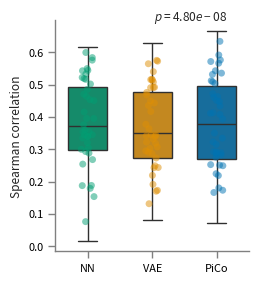

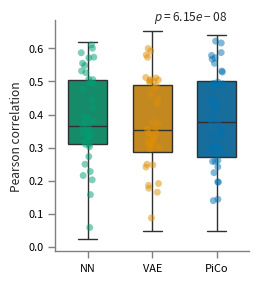

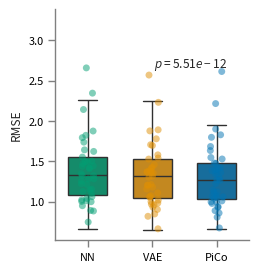

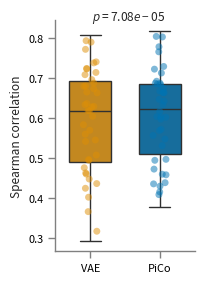

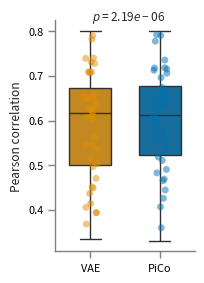

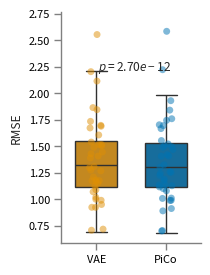

In [ ]:
# PERF PLOT ONE BOXPLOT
pal = sns.color_palette("colorblind", n_colors=5)

palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

for metric in [
    "spearman_r",
    "pearson_r",
    "rmse",
    "spearman_r_val",
    "pearson_r_val",
    "rmse_val",
]:
    perf_df_plot = perf_df.reset_index().drop("zdim", axis=1)

    order = sorted(target_dict.items(), key=lambda x: x[1])
    order = [key for key, val in order]
    drug_targets = sorted(list(set(target_dict.values())))

    pal = sns.color_palette("colorblind", n_colors=5)

    palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

    fe_dict = {"nn": "NN", "vae": "VAE", "icovae": "PiCo"}
    model_dict = {"SVR": "SVR", "ElasticNet": "ElasticNet", "transfer": "Transfer"}

    perf_df_plot["fe"] = perf_df_plot["fe"].map(fe_dict)
    perf_df_plot["model"] = perf_df_plot["model"].map(model_dict)
    perf_df_plot["drug_target"] = perf_df_plot["target"].map(target_dict)

    # If validation, drop nans
    if metric.split("_")[-1] == "val":
        perf_df_plot = perf_df_plot.dropna(axis=0)

    perf_df_best = (
        perf_df_plot.drop(["n_genes"], axis=1)
        .groupby(["fe", "target", "drug_target", "model"])
        .mean()
        .reset_index()
    )

    if metric == "rmse":
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target", "drug_target"])[metric].idxmin()
        ].set_index(["fe", "target", "drug_target", "model"])
        perf_df_plot = (
            perf_df_plot.drop(["n_genes"], axis=1)
            .set_index(["fe", "target", "drug_target", "model"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values("target", ascending=True)
        )
    else:
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target", "drug_target"])[metric].idxmax()
        ].set_index(["fe", "target", "drug_target", "model"])
        perf_df_plot = (
            perf_df_plot.drop(["n_genes"], axis=1)
            .set_index(["fe", "target", "drug_target", "model"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values("target", ascending=True)
        )

    if metric.split("_")[-1] == "val":
        fig, ax = plt.subplots(1, 1, figsize=(1.8, 3))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))

    if metric.split("_")[-1] == "val":
        order = ["VAE", "PiCo"]
    else:
        order = ["NN", "VAE", "PiCo"]
    sns.boxplot(
        data=perf_df_plot,
        x="fe",
        y=metric,
        ax=ax,
        hue="fe",
        palette=palette,
        fliersize=0,
        width=0.6,
        order=order,
    )
    sns.stripplot(
        data=perf_df_best,
        x="fe",
        y=metric,
        ax=ax,
        hue="fe",
        palette=palette,
        alpha=0.5,
        jitter=True,
        order=order,
    )
    if metric in ["spearman_r", "spearman_r_val"]:
        ax.set_ylabel("Spearman correlation")
    elif metric in ["pearson_r", "pearson_r_val"]:
        ax.set_ylabel("Pearson correlation")
    elif metric in ["rmse", "rmse_val"]:
        ax.set_ylabel("RMSE")
    ax.set_xlabel("")
    sns.despine(ax=ax)

    from scipy.stats import wilcoxon

    if metric.split("_")[-1] != "val":
        group1 = perf_df_plot[perf_df_plot["fe"] == "PiCo"][metric]
        group2 = perf_df_plot[perf_df_plot["fe"] == "NN"][metric]
        stat, p = wilcoxon(group1, group2)
        print(stat, p)

    group1 = perf_df_plot[perf_df_plot["fe"] == "PiCo"][metric]
    group2 = perf_df_plot[perf_df_plot["fe"] == "VAE"][metric]
    stat, p = wilcoxon(group1, group2)
    print(stat, p)

    # Then add with ax.text() or ax.annotate()
    if metric.split("_")[-1] == "val":
        if metric.split("_")[0] == "rmse":
            ax.text(x=0.26, y=0.75, s=f"$p = {p:.2e}$", transform=ax.transAxes)
        else:
            ax.text(x=0.26, y=1.00, s=f"$p = {p:.2e}$", transform=ax.transAxes)
    else:
        if metric.split("_")[0] == "rmse":
            ax.text(x=0.51, y=0.75, s=f"$p = {p:.2e}$", transform=ax.transAxes)
        else:
            ax.text(x=0.51, y=1.00, s=f"$p = {p:.2e}$", transform=ax.transAxes)

    plt.savefig(
        f"{wd_path}/results_analysis/figures/perf_comp_singlebox_{metric}_{experiment}.svg",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{wd_path}/results_analysis/figures/perf_comp_singlebox_{metric}_{experiment}.png",
        bbox_inches="tight",
        dpi=1200,
    )

[2.2 1.1 1.1 1.1 1.1 2.2 1.1 1.1 3.3 1.1 2.2 1.1]


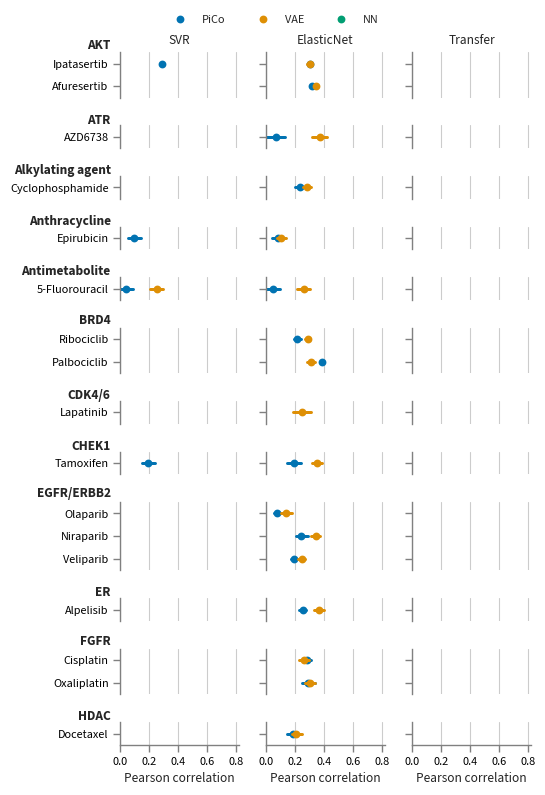

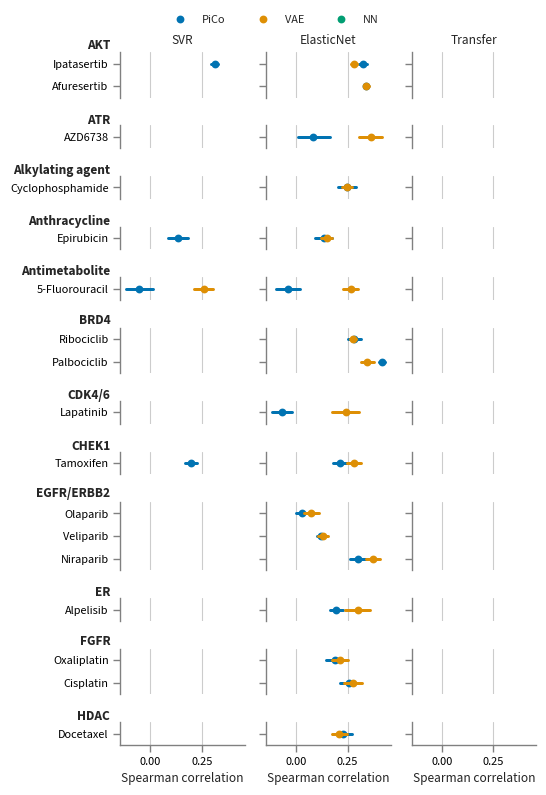

In [ ]:
## PERF PLOT 3 MODELS
pal = sns.color_palette("colorblind", n_colors=5)

palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

# Get best results using given feature extraction
perf_df_plot = perf_df.groupby(["target", "fe", "model"]).mean()

order = sorted(target_dict.items(), key=lambda x: x[1])
order = [key for key, val in order]
drug_targets = sorted(list(set(target_dict.values())))

fe_dict = {"nn": "NN", "vae": "VAE", "icovae": "PiCo"}
model_dict = {"SVR": "SVR", "ElasticNet": "ElasticNet", "transfer": "Transfer"}

perf_df_plot = perf_df.copy()

perf_df_plot["fe"] = perf_df_plot["fe"].map(fe_dict)
perf_df_plot["model"] = perf_df_plot["model"].map(model_dict)
perf_df_plot["drug_target"] = perf_df_plot["target"].map(target_dict)

hue_order = ["PiCo", "VAE", "NN"]

col_order = ["SVR", "ElasticNet", "Transfer"]

yranges = (
    perf_df_plot.groupby("drug_target")["target"].agg("nunique").to_numpy(dtype="float")
)
yranges *= 1.1  # Account for default margins

drug_targets_plot = [
    drug_target
    for drug_target in drug_targets
    if drug_target in set(perf_df_plot["drug_target"])
]

f = sns.catplot(
    perf_df_plot.sort_values("pearson_r"),
    x="pearson_r",
    y="target",
    hue="fe",
    col="model",
    row="drug_target",
    col_order=col_order,
    row_order=drug_targets_plot,
    palette=palette,
    hue_order=hue_order,
    markersize=4,
    kind="point",
    linestyle="none",
    height=0.65,
    aspect=2.5,
    sharey="row",
    facet_kws=dict(gridspec_kws={"height_ratios": yranges}),
)
f.set_axis_labels("Pearson correlation", "")
axes = f.axes.flatten()
axes[0].set_title("SVR")
axes[1].set_title("ElasticNet")
axes[2].set_title("Transfer")
for i, ax in enumerate(axes):
    if i % 3 == 0 and i < (len(axes) - 3):
        ax.text(
            s=drug_targets[i // 3],
            x=-0.08,
            y=1.08,
            transform=ax.transAxes,
            fontweight="bold",
            horizontalalignment="right",
        )
        ax.tick_params(
            top=False,
            bottom=False,
            left=True,
            right=False,
            labelleft=True,
            labelbottom=False,
        )
    elif i >= (len(axes) - 3) and i % 3 != 0:
        ax.tick_params(
            top=False,
            bottom=True,
            left=True,
            right=False,
            labelleft=False,
            labelbottom=True,
        )
    elif i >= (len(axes) - 3) and i % 3 == 0:
        ax.text(
            s=drug_targets[i // 3],
            x=-0.08,
            y=1.08,
            transform=ax.transAxes,
            fontweight="bold",
            horizontalalignment="right",
        )
        ax.tick_params(
            top=False,
            bottom=True,
            left=True,
            right=False,
            labelleft=True,
            labelbottom=True,
        )
    else:
        ax.tick_params(
            top=False,
            bottom=False,
            left=True,
            right=False,
            labelleft=False,
            labelbottom=False,
        )

    if i > 2:
        ax.set_title("")

    if i < (len(axes) - 3):
        sns.despine(ax=axes[i], bottom=True)

    ax.grid(visible=True, axis="x")
    ax.set_xlim(0, 0.82)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8], [0.0, 0.2, 0.4, 0.6, 0.8])

sns.move_legend(f, "upper center", bbox_to_anchor=(0.5, 1.02), title="", ncol=3)
plt.tight_layout()
plt.savefig(
    f"./figures/perf_comp_pearson_{experiment}_all.png", bbox_inches="tight", dpi=600
)
plt.savefig(f"./figures/perf_comp_pearson_{experiment}_all.svg", bbox_inches="tight")

f = sns.catplot(
    perf_df_plot.sort_values("spearman_r"),
    x="spearman_r",
    y="target",
    hue="fe",
    col="model",
    row="drug_target",
    col_order=col_order,
    row_order=drug_targets_plot,
    palette=palette,
    hue_order=hue_order,
    markersize=4,
    kind="point",
    linestyle="none",
    height=0.65,
    aspect=2.5,
    sharey="row",
    facet_kws=dict(gridspec_kws={"height_ratios": yranges}),
)
f.set_axis_labels("Spearman correlation", "")
axes = f.axes.flatten()
axes[0].set_title("SVR")
axes[1].set_title("ElasticNet")
axes[2].set_title("Transfer")
for i, ax in enumerate(axes):
    if i % 3 == 0 and i < (len(axes) - 3):
        ax.text(
            s=drug_targets[i // 3],
            x=-0.08,
            y=1.08,
            transform=ax.transAxes,
            fontweight="bold",
            horizontalalignment="right",
        )
        ax.tick_params(
            top=False,
            bottom=False,
            left=True,
            right=False,
            labelleft=True,
            labelbottom=False,
        )
    elif i >= (len(axes) - 3) and i % 3 != 0:
        ax.tick_params(
            top=False,
            bottom=True,
            left=True,
            right=False,
            labelleft=False,
            labelbottom=True,
        )
    elif i >= (len(axes) - 3) and i % 3 == 0:
        ax.text(
            s=drug_targets[i // 3],
            x=-0.08,
            y=1.08,
            transform=ax.transAxes,
            fontweight="bold",
            horizontalalignment="right",
        )
        ax.tick_params(
            top=False,
            bottom=True,
            left=True,
            right=False,
            labelleft=True,
            labelbottom=True,
        )
    else:
        ax.tick_params(
            top=False,
            bottom=False,
            left=True,
            right=False,
            labelleft=False,
            labelbottom=False,
        )

    if i > 2:
        ax.set_title("")

    if i < (len(axes) - 3):
        sns.despine(ax=axes[i], bottom=True)

    ax.grid(visible=True, axis="x")

sns.move_legend(f, "upper center", bbox_to_anchor=(0.5, 1.02), title="", ncol=3)
plt.tight_layout()
plt.savefig(
    f"./figures/perf_comp_spearman_{experiment}_all.png", bbox_inches="tight", dpi=600
)
plt.savefig(f"./figures/perf_comp_spearman_{experiment}_all.svg", bbox_inches="tight")

       fe          target     drug_target       model  index      rmse  \
0    PiCo  5-Fluorouracil  Antimetabolite  ElasticNet     21  1.790982   
170   VAE  5-Fluorouracil  Antimetabolite  ElasticNet      8  1.386258   
171   VAE  5-Fluorouracil  Antimetabolite  ElasticNet      9  1.429103   
172   VAE  5-Fluorouracil  Antimetabolite  ElasticNet     10  1.432893   
173   VAE  5-Fluorouracil  Antimetabolite  ElasticNet     11  1.398804   
..    ...             ...             ...         ...    ...       ...   
162  PiCo       Veliparib            PARP  ElasticNet    380  0.744744   
161  PiCo       Veliparib            PARP  ElasticNet    379  0.745176   
160  PiCo       Veliparib            PARP  ElasticNet    378  0.751451   
338   VAE       Veliparib            PARP  ElasticNet    387  0.752918   
339   VAE       Veliparib            PARP  ElasticNet    389  0.754683   

     pearson_r  spearman_r  rmse_val  pearson_r_val  spearman_r_val  seed  
0    -0.130781   -0.242556  1.54912

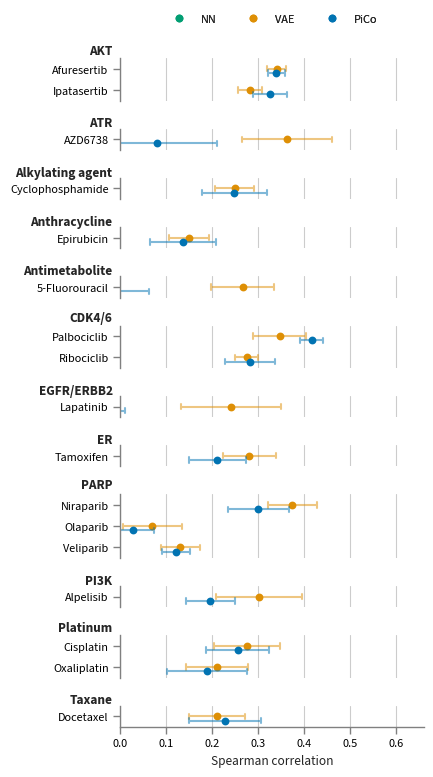

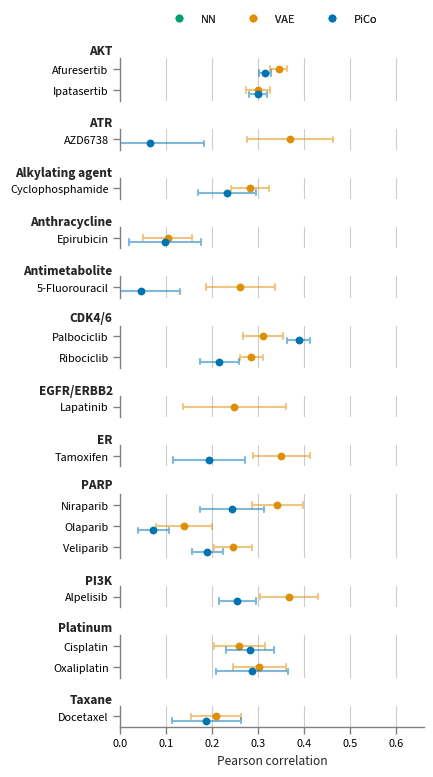

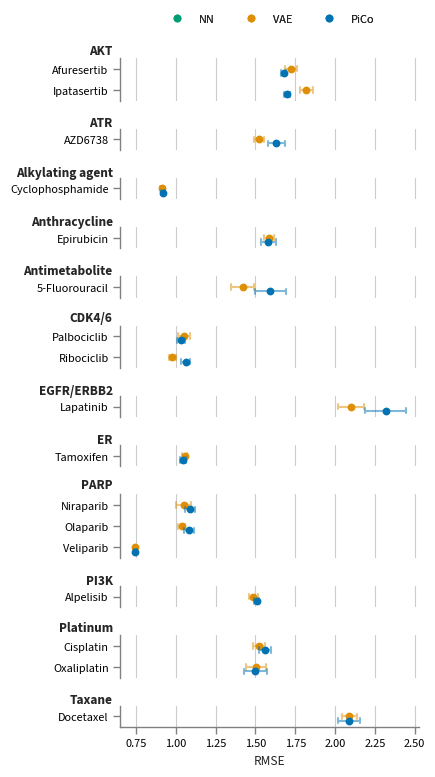

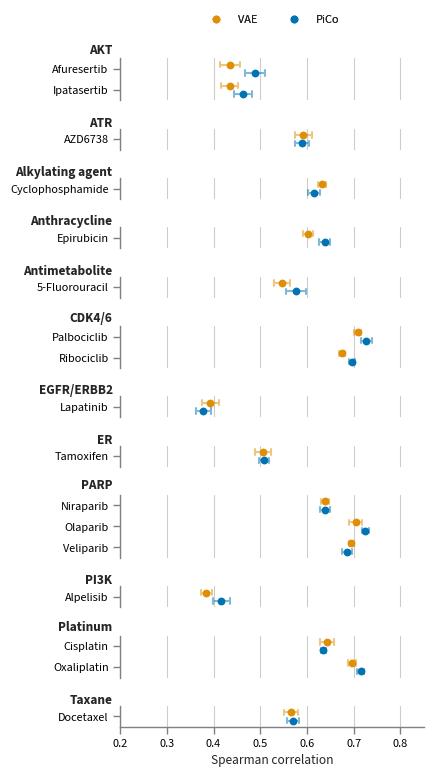

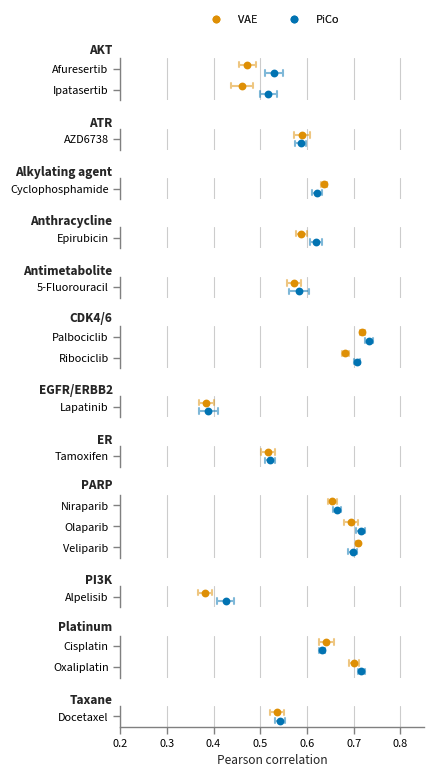

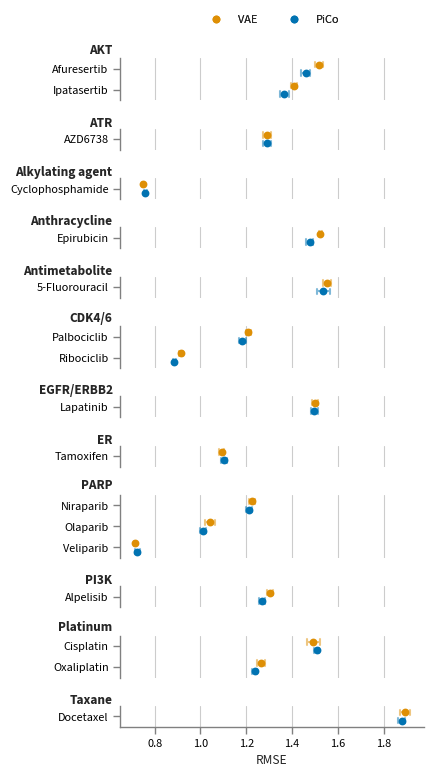

In [ ]:
# PERF COMP BEST
single_drug = None

for metric in [
    "spearman_r",
    "pearson_r",
    "rmse",
    "spearman_r_val",
    "pearson_r_val",
    "rmse_val",
]:
    perf_df_plot = perf_df.reset_index()

    order = sorted(target_dict.items(), key=lambda x: x[1])
    order = [key for key, val in order]
    drug_targets = sorted(list(set(target_dict.values())))

    pal = sns.color_palette("colorblind", n_colors=5)

    palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

    fe_dict = {"nn": "NN", "vae": "VAE", "icovae": "PiCo"}
    model_dict = {"SVR": "SVR", "ElasticNet": "ElasticNet", "transfer": "Transfer"}

    perf_df_plot["fe"] = perf_df_plot["fe"].map(fe_dict)
    perf_df_plot["model"] = perf_df_plot["model"].map(model_dict)
    perf_df_plot["drug_target"] = perf_df_plot["target"].map(target_dict)

    # If validation, drop nans
    if metric.split("_")[-1] == "val":
        perf_df_plot = perf_df_plot.dropna(axis=0)

    perf_df_best = (
        perf_df_plot.drop(["n_genes"], axis=1)
        .groupby(["fe", "target", "drug_target", "model"])
        .mean()
        .reset_index()
    )

    if metric == "rmse":
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target", "drug_target"])[metric].idxmin()
        ].set_index(["fe", "target", "drug_target", "model"])
        perf_df_plot = (
            perf_df_plot.drop(["n_genes"], axis=1)
            .set_index(["fe", "target", "drug_target", "model"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values("target", ascending=True)
        )
    else:
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target", "drug_target"])[metric].idxmax()
        ].set_index(["fe", "target", "drug_target", "model"])
        perf_df_plot = (
            perf_df_plot.drop(["n_genes"], axis=1)
            .set_index(["fe", "target", "drug_target", "model"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values("target", ascending=True)
        )

    if single_drug is not None:
        perf_df_plot = perf_df_plot[perf_df_plot["target"] == single_drug]

    if metric.split("_")[-1] == "val":
        hue_order = ["VAE", "PiCo"]
    else:
        hue_order = ["NN", "VAE", "PiCo"]

    col_order = ["SVR", "ElasticNet", "Transfer"]

    yranges = (
        perf_df_plot.groupby("drug_target")["target"]
        .agg("nunique")
        .to_numpy(dtype="float")
    )
    yranges *= 1.1  # Account for default margins

    drug_targets_plot = [
        drug_target
        for drug_target in drug_targets
        if drug_target in set(perf_df_plot["drug_target"])
    ]

    f = sns.catplot(
        perf_df_plot,
        x=metric,
        y="target",
        hue="fe",
        row="drug_target",
        row_order=drug_targets_plot,
        palette=palette,
        hue_order=hue_order,
        markersize=4,
        kind="point",
        linestyle="none",
        height=0.625,
        aspect=6,
        sharey="row",
        capsize=0.25,
        errorbar=("sd", 1),
        facet_kws=dict(gridspec_kws={"height_ratios": yranges}),
        err_kws={"linewidth": 1.5, "alpha": 0.5},
        dodge=0.4,
    )
    if metric == "rmse":
        f.set_axis_labels("RMSE", "")
    elif metric == "pearson_r":
        f.set_axis_labels("Pearson correlation", "")
    elif metric == "spearman_r":
        f.set_axis_labels("Spearman correlation", "")
    elif metric == "spearman_r_val":
        f.set_axis_labels("Spearman correlation", "")
    elif metric == "pearson_r_val":
        f.set_axis_labels("Pearson correlation", "")
    elif metric == "rmse_val":
        f.set_axis_labels("RMSE", "")
    axes = f.axes.flatten()
    for i, ax in enumerate(axes):
        if i < (len(axes) - 1):
            ax.text(
                s=drug_targets_plot[i],
                x=-0.025,
                y=1.1,
                transform=ax.transAxes,
                fontweight=800,
                horizontalalignment="right",
            )
            ax.tick_params(
                top=False,
                bottom=False,
                left=True,
                right=False,
                labelleft=True,
                labelbottom=False,
            )
        elif i >= (len(axes) - 1):
            ax.text(
                s=drug_targets_plot[i],
                x=-0.025,
                y=1.1,
                transform=ax.transAxes,
                fontweight=800,
                horizontalalignment="right",
            )
            ax.tick_params(
                top=False,
                bottom=True,
                left=True,
                right=False,
                labelleft=True,
                labelbottom=True,
            )
        else:
            ax.tick_params(
                top=False,
                bottom=False,
                left=True,
                right=False,
                labelleft=False,
                labelbottom=False,
            )

        ax.set_title("")

        if i < (len(axes) - 1):
            sns.despine(ax=axes[i], bottom=True)

        ax.grid(visible=True, axis="x")
        if metric.split("_")[0] != "rmse":
            if metric.split("_")[-1] != "val":
                ax.set_xlim(0, 0.66)
                ax.set_xticks(
                    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                )
            else:
                ax.set_xlim(0.2, 0.85)
                ax.set_xticks(
                    [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                    [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                )

    handles, labels = plt.gca().get_legend_handles_labels()

    leg1 = axes[0].legend(
        handles=handles,
        bbox_to_anchor=(0.5, 2.3),
        loc="upper center",
        frameon=False,
        ncol=3,
    )

    axes[0].add_artist(leg1)

    f._legend.remove()

    plt.tight_layout()
    if single_drug is not None:
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_{single_drug}.png",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_{single_drug}.svg",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
        )
    else:
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}.png",
            # bbox_inches="tight",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}.svg",
            # bbox_inches="tight",
            bbox_extra_artists=(leg1,),
        )

In [13]:
# Get ranking of models for each metric
for metric in [
    "rmse",
    "pearson_r",
    "spearman_r",
    "rmse_val",
    "pearson_r_val",
    "spearman_r_val",
]:
    perf_df_best = (
        perf_df.drop(["n_genes", "zdim"], axis=1)
        .groupby(["fe", "target", "model"])
        .mean()
        .reset_index()
    )

    if metric.split("_")[-1] == "val":
        perf_df_best = perf_df_best.dropna(axis=0)

    if metric == "rmse":
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target"])[metric].idxmin()
        ]
    else:
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target"])[metric].idxmax()
        ]

    if metric == "rmse":
        perf_df_best[f"{metric}_rank"] = perf_df_best.groupby("target").rank(
            ascending=True
        )[metric]
    else:
        perf_df_best[f"{metric}_rank"] = perf_df_best.groupby("target").rank(
            ascending=False
        )[metric]

    print(perf_df_best[["fe", f"{metric}_rank"]].groupby("fe").value_counts())
    print(perf_df_best[["fe", f"{metric}_rank"]].groupby("fe").mean())

fe      rmse_rank
icovae  1.0          27
        2.0          11
        3.0           2
nn      3.0          35
        2.0           3
        1.0           2
vae     2.0          26
        1.0          11
        3.0           3
dtype: int64
        rmse_rank
fe               
icovae      1.375
nn          2.825
vae         1.800
fe      pearson_r_rank
icovae  1.0               16
        3.0               14
        2.0               10
nn      1.0               18
        2.0               13
        3.0                9
vae     2.0               17
        3.0               17
        1.0                6
dtype: int64
        pearson_r_rank
fe                    
icovae           1.950
nn               1.775
vae              2.275
fe      spearman_r_rank
icovae  1.0                18
        3.0                14
        2.0                 8
nn      1.0                17
        2.0                15
        3.0                 8
vae     3.0                18
        2.0      

       fe    target       model      rmse  pearson_r  spearman_r  rmse_val  \
490  PiCo  Axitinib  ElasticNet  1.102058   0.640112    0.665817  1.189363   
498  PiCo  Axitinib  ElasticNet  1.118236   0.635975    0.650294  1.185241   
499  PiCo  Axitinib  ElasticNet  1.118231   0.626318    0.647744  1.172726   
493  PiCo  Axitinib  ElasticNet  1.112270   0.629285    0.639292  1.171489   
495  PiCo  Axitinib  ElasticNet  1.111137   0.630693    0.634742  1.177685   
..    ...       ...         ...       ...        ...         ...       ...   
10     NN   AZD5153  ElasticNet  1.791674   0.035598    0.062271       NaN   
14     NN   AZD5153  ElasticNet  1.681804   0.032495    0.061165       NaN   
17     NN   AZD5153  ElasticNet  1.853341   0.048657    0.056482       NaN   
18     NN   AZD5153  ElasticNet  2.198098   0.025046    0.031797       NaN   
11     NN   AZD5153  ElasticNet  1.689043   0.017580    0.015977       NaN   

     pearson_r_val  spearman_r_val  seed  zdim  
490       0.72

/tmp/ipykernel_2027336/907411749.py:186: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_2027336/907411749.py:186: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_2027336/907411749.py:186: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(


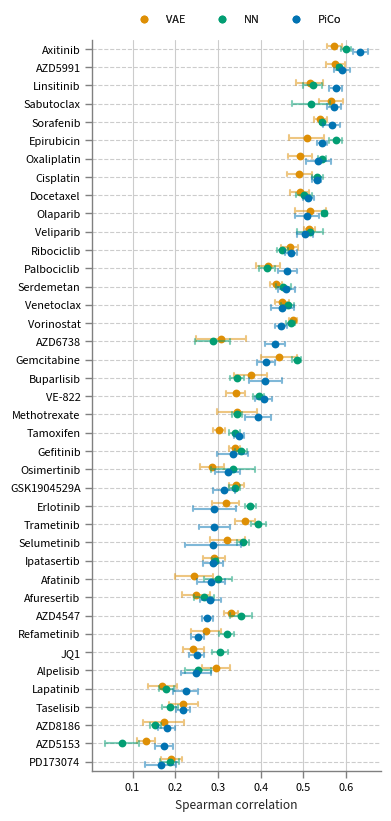

In [ ]:
# Not including drug class
# PERF COMP BEST
for metric in [
    "rmse",
    "pearson_r",
    "spearman_r",
    "rmse_val",
    "pearson_r_val",
    "spearman_r_val",
]:
    single_drug = None

    order = sorted(target_dict.items(), key=lambda x: x[1])
    order = [key for key, val in order]
    drug_targets = sorted(list(set(target_dict.values())))

    pal = sns.color_palette("colorblind", n_colors=5)

    palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

    fe_dict = {"nn": "NN", "vae": "VAE", "icovae": "PiCo"}
    model_dict = {"SVR": "SVR", "ElasticNet": "ElasticNet", "transfer": "Transfer"}

    perf_df_plot = perf_df.copy()

    perf_df_plot["fe"] = perf_df_plot["fe"].map(fe_dict)
    perf_df_plot["model"] = perf_df_plot["model"].map(model_dict)

    perf_df_best = (
        perf_df_plot.drop(["n_genes"], axis=1)
        .groupby(["fe", "target", "model"])
        .mean()
        .reset_index()
    )
    if metric == "rmse":
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target"])[metric].idxmin()
        ].set_index(["fe", "target", "model"])
        perf_df_plot = (
            perf_df_plot.drop(["n_genes"], axis=1)
            .set_index(["fe", "target", "model"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values(metric, ascending=True)
        )
        plot_order = (
            perf_df_best.loc["PiCo"]
            .sort_values(by=metric, ascending=True)
            .reset_index()["target"]
            .tolist()
        )
    else:
        perf_df_best = perf_df_best.loc[
            perf_df_best.groupby(["fe", "target"])[metric].idxmax()
        ].set_index(["fe", "target", "model"])
        perf_df_plot = (
            perf_df_plot.drop(["n_genes"], axis=1)
            .set_index(["fe", "target", "model"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values(metric, ascending=False)
        )
        plot_order = (
            perf_df_best.loc["PiCo"]
            .sort_values(by=metric, ascending=False)
            .reset_index()["target"]
            .tolist()
        )

    if single_drug is not None:
        perf_df_plot = perf_df_plot[perf_df_plot["target"] == single_drug]

    hue_order = ["VAE", "NN", "PiCo"]

    col_order = ["SVR", "ElasticNet", "Transfer"]

    fig, ax = plt.subplots(1, 1, figsize=(4, len(plot_order) // 5))

    sns.pointplot(
        perf_df_plot,
        x=metric,
        y="target",
        hue="fe",
        palette=palette,
        order=plot_order,
        hue_order=hue_order,
        dodge=0.3,
        markersize=4,
        linestyle="none",
        capsize=0.25,
        errorbar=("sd", 1),
        # errorbar=None,
        err_kws={"linewidth": 1.5, "alpha": 0.5},
        ax=ax,
    )
    if metric == "rmse":
        ax.set_xlabel("RMSE")
    elif metric == "pearson_r":
        ax.set_xlabel("Pearson correlation")
    elif metric == "spearman_r":
        ax.set_xlabel("Spearman correlation")

    ax.set_title("")

    ax.grid(visible=True, axis="x")
    ax.grid(visible=True, axis="y", linestyle="--")

    handles, labels = plt.gca().get_legend_handles_labels()

    leg1 = ax.legend(
        handles=handles,
        bbox_to_anchor=(0.5, 1.05),
        loc="upper center",
        frameon=False,
        ncol=3,
    )

    ax.add_artist(leg1)

    ax.set_ylabel("")

    sns.despine(ax=ax)

    plt.tight_layout()
    if single_drug is not None:
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_{single_drug}_notarget.png",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_{single_drug}_notarget.svg",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
        )
    else:
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_notarget.png",
            # bbox_inches="tight",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_notarget.svg",
            # bbox_inches="tight",
            bbox_extra_artists=(leg1,),
        )

In [ ]:
gdsc_ctrp_drug_alias = {
    "SORAFENIB": "SORAFENIB",
    "AXITINIB": "AXITINIB",
    "DOCETAXEL": "DOCETAXEL",
    "OXALIPLATIN": "OXALIPLATIN",
    "VELIPARIB": "VELIPARIB",
    "OLAPARIB": "OLAPARIB",
    "SELUMETINIB": "SELUMETINIB",
    "TRAMETINIB": "TRAMETINIB",
    "SERDEMETAN": "SERDEMETAN",
    "VENETOCLAX": "ABT-199",
    "LINSITINIB": "LINSITINIB",
    "VORINOSTAT": "VORINOSTAT",
    "AZD4547": "AZD4547",
    "TAMOXIFEN": "TAMOXIFEN",
    "AFATINIB": "AFATINIB",
    "LAPATINIB": "LAPATINIB",
    "GEFITINIB": "GEFITINIB",
    "ERLOTINIB": "ERLOTINIB",
}
gdsc_prism_drug_alias = {
    "SORAFENIB": "284461-73-0",
    "AXITINIB": "AG-13736",
    "DOCETAXEL": "DOCETAXEL",
    "IRINOTECAN": "IRINOTECAN",
    "CISPLATIN": "CIS-DDP",
    "OXALIPLATIN": "ELOXATIN",
    "GSK2830371A": "GSK2830371",
    "AZD8186": "AZD 8186",
    "TASELISIB": "TASELISIB",
    "CZC24832": "CZC24832",
    "BUPARLISIB": "BKM120",
    "VELIPARIB": "ABT 888",
    "OLAPARIB": "OLAPARIB",
    "SELUMETINIB": "ARRY-886",
    "REFAMETINIB": "BAY 869766",
    "TRAMETINIB": "TRAMETINIB",
    "SERDEMETAN": "JNJ-26854165",
    "AZD5991": "AZD5991",
    "VENETOCLAX": "VENETOCLAX",
    "GSK1904529A": "GSK 1904529A",
    "LINSITINIB": "ASP-7487",
    "PD173074": "PD 173074",
    "AZD4547": "1035270-39-3",
    "TAMOXIFEN": "ICI-46474",
}

       fe      target drug_target       model      rmse  pearson_r  \
460  PiCo    Axitinib       VEGFR  ElasticNet  1.101976   0.640599   
466  PiCo    Axitinib       VEGFR  ElasticNet  1.125635   0.618849   
465  PiCo    Axitinib       VEGFR  ElasticNet  1.124776   0.628938   
188    NN  Irinotecan        TOP1  ElasticNet  1.740423   0.618691   
183    NN  Irinotecan        TOP1  ElasticNet  1.525990   0.625110   
..    ...         ...         ...         ...       ...        ...   
14     NN     AZD5153        BRD4  ElasticNet  1.681804   0.032495   
16     NN     AZD5153        BRD4  ElasticNet  1.853341   0.048657   
874   VAE     AZD8186        PI3K         SVR  1.458652   0.053290   
18     NN     AZD5153        BRD4  ElasticNet  2.198098   0.025046   
11     NN     AZD5153        BRD4  ElasticNet  1.689043   0.017580   

     spearman_r  zdim  
460    0.656640   NaN  
466    0.645897   NaN  
465    0.640057   NaN  
188    0.635661   NaN  
183    0.632603   NaN  
..          ...

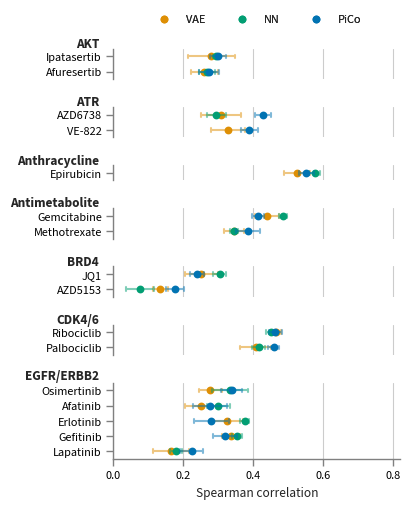

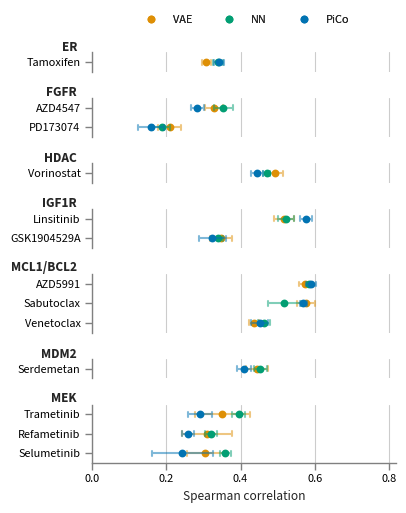

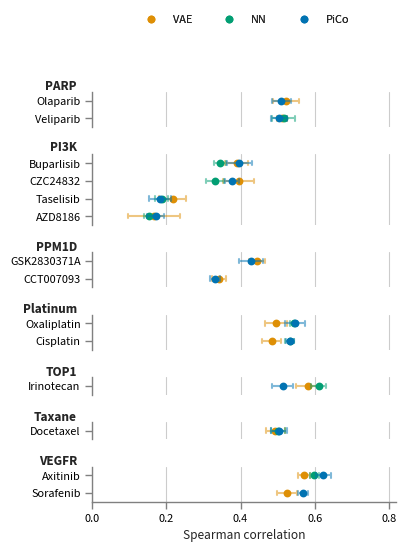

In [ ]:
# PERF COMP BEST FOR SLIDES
metric = "spearman_r"
single_drug = None

order = sorted(target_dict.items(), key=lambda x: x[1])
order = [key for key, val in order]
drug_targets = sorted(list(set(target_dict.values())))

fe_dict = {"nn": "NN", "vae": "VAE", "icovae": "PiCo"}
model_dict = {"SVR": "SVR", "ElasticNet": "ElasticNet", "transfer": "Transfer"}

palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

perf_df_plot = perf_df.copy()

perf_df_plot["fe"] = perf_df_plot["fe"].map(fe_dict)
perf_df_plot["model"] = perf_df_plot["model"].map(model_dict)
perf_df_plot["drug_target"] = perf_df_plot["target"].map(target_dict)

perf_df_best = (
    perf_df_plot.drop(["n_genes"], axis=1)
    .groupby(["fe", "target", "drug_target", "model"])
    .mean()
    .reset_index()
)
if metric == "rmse":
    perf_df_best = perf_df_best.loc[
        perf_df_best.groupby(["fe", "target", "drug_target"])[metric].idxmin()
    ].set_index(["fe", "target", "drug_target", "model"])
    perf_df_plot = (
        perf_df_plot.drop(["n_genes"], axis=1)
        .set_index(["fe", "target", "drug_target", "model"])
        .loc[perf_df_best.index]
        .reset_index()
        .sort_values(metric, ascending=True)
    )
else:
    perf_df_best = perf_df_best.loc[
        perf_df_best.groupby(["fe", "target", "drug_target"])[metric].idxmax()
    ].set_index(["fe", "target", "drug_target", "model"])
    perf_df_plot = (
        perf_df_plot.drop(["n_genes"], axis=1)
        .set_index(["fe", "target", "drug_target", "model"])
        .loc[perf_df_best.index]
        .reset_index()
        .sort_values(metric, ascending=False)
    )

if single_drug is not None:
    perf_df_plot = perf_df_plot[perf_df_plot["drug"] == single_drug]

hue_order = ["VAE", "NN", "PiCo"]

col_order = ["SVR", "ElasticNet", "Transfer"]

drug_targets_plot = [
    target for target in drug_targets if target in set(perf_df_plot["drug_target"])
]

perf_df_plot_1 = perf_df_plot[perf_df_plot["drug_target"].isin(drug_targets_plot[:7])]
perf_df_plot_2 = perf_df_plot[perf_df_plot["drug_target"].isin(drug_targets_plot[7:14])]
perf_df_plot_3 = perf_df_plot[perf_df_plot["drug_target"].isin(drug_targets_plot[14:])]

perf_df_plot_list = [perf_df_plot_1, perf_df_plot_2, perf_df_plot_3]
drug_targets_plot_list = [
    drug_targets_plot[:7],
    drug_targets_plot[7:14],
    drug_targets_plot[14:],
]

for i, data in enumerate(perf_df_plot_list):
    yranges = (
        data.groupby("drug_target")["target"].agg("nunique").to_numpy(dtype="float")
    )
    yranges *= 1.1  # Account for default margins

    f = sns.catplot(
        data,
        x=metric,
        y="target",
        hue="fe",
        row="drug_target",
        row_order=drug_targets_plot_list[i],
        palette=palette,
        hue_order=hue_order,
        markersize=4,
        kind="point",
        linestyle="none",
        height=0.7,
        aspect=5,
        sharey="row",
        capsize=0.25,
        errorbar=("sd", 1),
        facet_kws=dict(gridspec_kws={"height_ratios": yranges}),
        err_kws={"linewidth": 1.5, "alpha": 0.5},
    )
    if metric == "rmse":
        f.set_axis_labels("RMSE", "")
    elif metric == "pearson_r":
        f.set_axis_labels("Pearson correlation", "")
    elif metric == "spearman_r":
        f.set_axis_labels("Spearman correlation", "")
    axes = f.axes.flatten()
    for j, ax in enumerate(axes):
        if j < (len(axes) - 1):
            ax.text(
                s=drug_targets_plot_list[i][j],
                x=-0.05,
                y=1.05,
                transform=ax.transAxes,
                fontweight="bold",
                horizontalalignment="right",
            )
            ax.tick_params(
                top=False,
                bottom=False,
                left=True,
                right=False,
                labelleft=True,
                labelbottom=False,
            )
        elif j >= (len(axes) - 1):
            ax.text(
                s=drug_targets_plot_list[i][j],
                x=-0.05,
                y=1.05,
                transform=ax.transAxes,
                fontweight="bold",
                horizontalalignment="right",
            )
            ax.tick_params(
                top=False,
                bottom=True,
                left=True,
                right=False,
                labelleft=True,
                labelbottom=True,
            )
        else:
            ax.tick_params(
                top=False,
                bottom=False,
                left=True,
                right=False,
                labelleft=False,
                labelbottom=False,
            )

        ax.set_title("")

        if j < (len(axes) - 1):
            sns.despine(ax=axes[j], bottom=True)

        ax.grid(visible=True, axis="x")
        if metric != "rmse":
            ax.set_xlim(0, 0.82)
            ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8], [0.0, 0.2, 0.4, 0.6, 0.8])

    handles, labels = plt.gca().get_legend_handles_labels()

    if i == 0:
        leg1 = axes[0].legend(
            handles=handles,
            bbox_to_anchor=(0.5, 2.5),
            loc="upper center",
            frameon=False,
            ncol=3,
        )
    else:
        leg1 = axes[0].legend(
            handles=handles,
            bbox_to_anchor=(0.5, 3.5),
            loc="upper center",
            frameon=False,
            ncol=3,
        )

    axes[0].add_artist(leg1)

    f._legend.remove()

    # sns.move_legend(f, "upper right", bbox_to_anchor=(0.95,0.95), title='Method')
    plt.tight_layout()
    if single_drug is not None:
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_{single_drug}_slides_{i}.png",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_{single_drug}_slides_{i}.svg",
            bbox_extra_artists=(leg1,),
        )
    else:
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_slides_{i}.png",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_{experiment}_slides_{i}.svg",
            bbox_extra_artists=(leg1,),
        )

### 2.1.2 Performance comparison split by type

In [25]:
target_dict = {
    "AZD5991": "MCL1/BCL2",
    "Alpelisib": "PI3K",
    "AZD8186": "PI3K",
    "Gefitinib": "EGFR/ERBB2",
    "Lapatinib": "EGFR/ERBB2",
    "Sorafenib": "VEGFR",
    "Docetaxel": "Taxane",
    "Paclitaxel": "Taxane",
    "Taselisib": "PI3K",
    "Palbociclib": "CDK4/6",
    "AZD3759": "EGFR/ERBB2",
    "Afatinib": "EGFR/ERBB2",
    "Afuresertib": "AKT",
    "Serdemetan": "MDM2",
    "Oxaliplatin": "Platinum",
    "GSK1904529A": "IGF1R",
    "Buparlisib": "PI3K",
    "Linsitinib": "IGF1R",
    "Ipatasertib": "AKT",
    "CZC24832": "PI3K",
    "Sabutoclax": "MCL1/BCL2",
    "MK-8776": "CHEK1",
    "Ribociclib": "CDK4/6",
    "Cisplatin": "Platinum",
    "Osimertinib": "EGFR/ERBB2",
    "Erlotinib": "EGFR/ERBB2",
    "AZD6738": "ATR",
    "Olaparib": "PARP",
    "Niraparib": "PARP",
    "Veliparib": "PARP",
    "MK-1775": "WEE1",
    "Cyclophosphamide": "Alkylating agent",
    "5-Fluorouracil": "Antimetabolite",
    "Epirubicin": "Anthracycline",
    "Tamoxifen": "ER",
    "Methotrexate": "Antimetabolite",
    "Venetoclax": "MCL1/BCL2",
    "AZD5153": "BRD4",
    "JQ1": "BRD4",
    "PD173074": "FGFR",
    "Saptinib": "EGFR/ERBB2",
    "AZD4547": "FGFR",
    "Vorinostat": "HDAC",
    "Refametinib": "MEK",
    "Selumetinib": "MEK",
    "Trametinib": "MEK",
    "Axitinib": "VEGFR",
    "GSK2830371A": "PPM1D",
    "CCT007093": "PPM1D",
    "Gemcitabine": "Antimetabolite",
    "Irinotecan": "TOP1",
    "VE-822": "ATR",
}

In [26]:
drug = "AZD6738"
experiment = "h16"

comp = PerfComp([drug], experiment, dataset="depmap_gdsc", wd_path=wd_path)

fes = ["icovae", "vae", "nn"]
models = ["SVR", "ElasticNet"]
perf_df_type = comp.calculate_perf(fes, models, by_type=True, use_cache=True)

497
181
522
250

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 16)
y                                  (1450, 1)
--------------------------------------------------
497
181
522
250

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 16)
y                                  (1450, 1)
--------------------------------------------------
497
181
522
250

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  

In [27]:
perf_df_means = (
    perf_df_type.groupby(["target", "model", "fe", "lineage"]).mean().reset_index()
)
perf_df_means[perf_df_means["lineage"] == "Breast"]

,target,model,fe,lineage,n_genes,rmse,pearson_r,spearman_r,rmse_val,pearson_r_val,spearman_r_val,seed
3,AZD6738,ElasticNet,icovae,Breast,16.0,NaN,NaN,NaN,1.664856,0.568688,0.651786,55.0
36,AZD6738,ElasticNet,vae,Breast,2.0,NaN,NaN,NaN,1.557638,0.655166,0.710714,55.0
58,AZD6738,SVR,icovae,Breast,16.0,NaN,NaN,NaN,1.616701,0.630012,0.687857,55.0


In [29]:
perf_df_type

,target,model,fe,lineage,n_genes,rmse,pearson_r,spearman_r,rmse_val,pearson_r_val,spearman_r_val,seed
0,AZD6738,SVR,icovae,Prostate,16.0,1.290122,0.084167,0.485714,NaN,NaN,NaN,10
580,AZD6738,ElasticNet,vae,Bladder/Urinary Tract,2.0,1.134232,0.243631,0.217647,NaN,NaN,NaN,70
581,AZD6738,ElasticNet,vae,Peripheral Nervous System,2.0,1.209555,0.459121,0.321078,NaN,NaN,NaN,70
582,AZD6738,ElasticNet,vae,Uterus,2.0,1.500880,-0.070351,-0.129412,NaN,NaN,NaN,70
583,AZD6738,ElasticNet,vae,Breast,2.0,NaN,NaN,NaN,1.584922,0.677897,0.775000,70
...,...,...,...,...,...,...,...,...,...,...,...,...
297,AZD6738,ElasticNet,icovae,Breast,16.0,NaN,NaN,NaN,1.798443,0.397348,0.489286,40
298,AZD6738,ElasticNet,icovae,Soft Tissue,16.0,NaN,NaN,NaN,0.976945,0.991408,1.000000,40
299,AZD6738,ElasticNet,icovae,Ovary/Fallopian Tube,16.0,NaN,NaN,NaN,1.847987,0.792635,0.428571,40
288,AZD6738,ElasticNet,icovae,Thyroid,16.0,1.448718,0.277779,0.069930,NaN,NaN,NaN,40


                                        rmse
fe   target  model      lineage             
NN   AZD6738 ElasticNet Bladder/UT  1.277128
                        Bone        1.360886
                        Cervix      1.102635
                        Kidney      1.474589
                        Liver       1.814079
                        PNS         1.345137
                        Pleura      2.156492
                        Prostate    1.412349
                        Testis      1.165812
                        Thyroid     1.454695
                        Uterus      1.539628
PiCo AZD6738 ElasticNet Bladder/UT  1.225135
                        Bone        1.178165
                        Cervix      0.734890
                        Kidney      1.252039
             SVR        Liver       1.531017
                        PNS         1.132470
                        Pleura      2.257475
                        Prostate    1.288723
                        Testis      0.676189
          

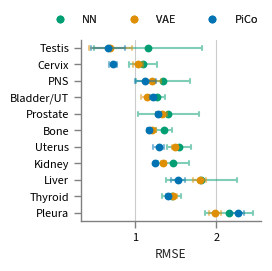

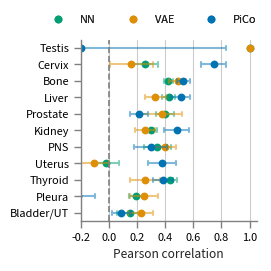

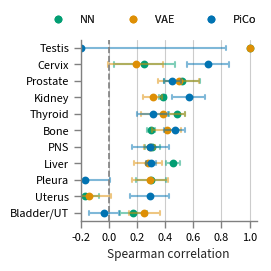

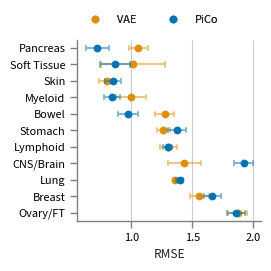

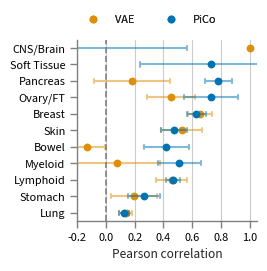

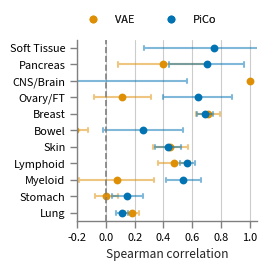

In [ ]:
# PERF COMP BEST TYPE -- TEST
lineage_dict = {
    "Prostate": "Prostate",
    "Uterus": "Uterus",
    "Cervix": "Cervix",
    "Bone": "Bone",
    "Liver": "Liver",
    "Bladder/Urinary Tract": "Bladder/UT",
    "Thyroid": "Thyroid",
    "Peripheral Nervous System": "PNS",
    "Kidney": "Kidney",
    "Pleura": "Pleura",
    "Testis": "Testis",
    "Ovary/Fallopian Tube": "Ovary/FT",
    "Lung": "Lung",
    "Breast": "Breast",
    "CNS/Brain": "CNS/Brain",
    "Head and Neck": "Head/Neck",
    "Pancreas": "Pancreas",
    "Soft Tissue": "Soft Tissue",
    "Esophagus/Stomach": "Stomach",
    "Bowel": "Bowel",
    "Skin": "Skin",
    "Lymphoid": "Lymphoid",
    "Myeloid": "Myeloid",
}

order = sorted(target_dict.items(), key=lambda x: x[1])
order = [key for key, val in order]
drug_targets = sorted(list(set(target_dict.values())))

pal = sns.color_palette("colorblind", n_colors=5)

palette = {"PiCo": pal[0], "VAE": pal[1], "NN": pal[2]}

fe_dict = {"nn": "NN", "vae": "VAE", "icovae": "PiCo"}
model_dict = {"SVR": "SVR", "ElasticNet": "ElasticNet", "transfer": "Transfer"}


for metric in [
    "rmse",
    "pearson_r",
    "spearman_r",
    "rmse_val",
    "pearson_r_val",
    "spearman_r_val",
]:
    perf_df_plot = perf_df_type.copy()

    perf_df_plot["fe"] = perf_df_plot["fe"].map(fe_dict)
    perf_df_plot["model"] = perf_df_plot["model"].map(model_dict)
    perf_df_plot["lineage"] = perf_df_plot["lineage"].map(lineage_dict)

    perf_df_plot = perf_df_plot[["fe", "target", "model", "lineage", metric]].dropna(
        axis=0
    )

    perf_df_best = (
        perf_df_plot.groupby(["fe", "target", "model", "lineage"]).mean().reset_index()
    )

    perf_df_best = perf_df_best.loc[
        perf_df_best.groupby(["fe", "target", "lineage"])[metric].idxmax()
    ].set_index(["fe", "target", "model", "lineage"])

    print(perf_df_best)

    if metric.split("_")[0] == "rmse":
        perf_df_plot = (
            perf_df_plot.set_index(["fe", "target", "model", "lineage"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values(metric, ascending=True)
        )
    else:
        perf_df_plot = (
            perf_df_plot.set_index(["fe", "target", "model", "lineage"])
            .loc[perf_df_best.index]
            .reset_index()
            .sort_values(metric, ascending=False)
        )

    if metric.split("_")[-1] == "val":
        hue_order = ["VAE", "PiCo"]
    else:
        hue_order = ["NN", "VAE", "PiCo"]

    col_order = ["SVR", "ElasticNet", "Transfer"]

    yranges = perf_df_plot.groupby("target")["lineage"].agg("nunique")
    yranges *= 1.1  # Account for default margins

    print(perf_df_plot)

    f = sns.catplot(
        perf_df_plot,
        x=metric,
        y="lineage",
        hue="fe",
        col="target",
        palette=palette,
        hue_order=hue_order,
        markersize=4,
        kind="point",
        linestyle="none",
        height=2.5,
        aspect=0.85,
        sharey=True,
        capsize=0.25,
        errorbar=("sd", 1),
        err_kws={"linewidth": 1.5, "alpha": 0.5},
    )
    if metric.split("_")[0] == "spearman":
        f.set_axis_labels("Spearman correlation", "")
    elif metric.split("_")[0] == "pearson":
        f.set_axis_labels("Pearson correlation", "")
    elif metric.split("_")[0] == "rmse":
        f.set_axis_labels("RMSE", "")
    axes = f.axes.flatten()
    for i, ax in enumerate(axes):
        ax.tick_params(
            top=False,
            bottom=True,
            left=True,
            right=False,
            labelleft=True,
            labelbottom=True,
        )

        ax.set_title("")

        ax.grid(visible=True, axis="x")
        if metric.split("_")[0] != "rmse":
            ax.set_xlim(-0.2, 1.05)
            ax.set_xticks(
                [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
            )
            ax.axvline(0, linestyle="--", color="grey")

    handles, labels = plt.gca().get_legend_handles_labels()

    leg1 = axes[0].legend(
        handles=handles,
        bbox_to_anchor=(0.4, 1.2),
        loc="upper center",
        frameon=False,
        ncol=3,
    )

    axes[0].add_artist(leg1)

    f._legend.remove()

    plt.tight_layout()
    if metric.split("_")[-1] == "val":
        plt.savefig(
            f"./figures/perf_comp_{metric}_type_{drug}_train.png",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_type_{drug}_train.svg",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
        )
    else:
        plt.savefig(
            f"./figures/perf_comp_{metric}_type_{drug}.png",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
            dpi=600,
        )
        plt.savefig(
            f"./figures/perf_comp_{metric}_type_{drug}.svg",
            bbox_inches="tight",
            bbox_extra_artists=(leg1,),
        )

### 2.1.3 Scatter plots for individual drugs

FileNotFoundError: [Errno 2] No such file or directory: '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc/ERLOTINIB/h16/pico/ElasticNet_icovae/z_pred_test_s90.1.csv'

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


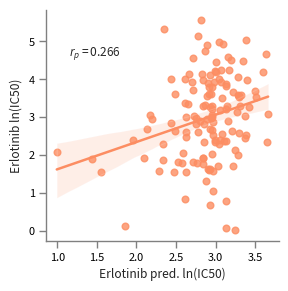

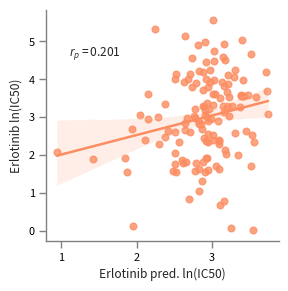

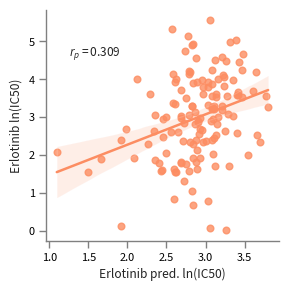

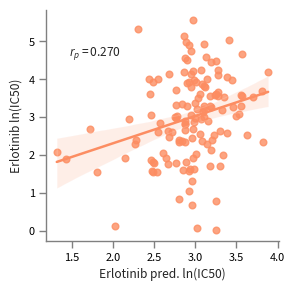

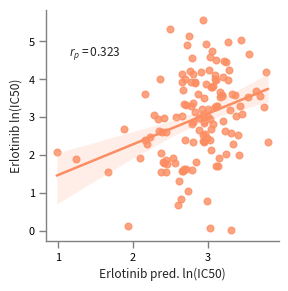

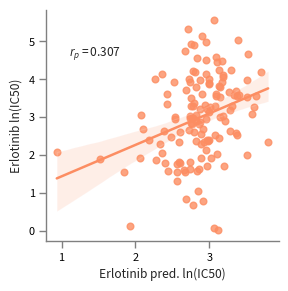

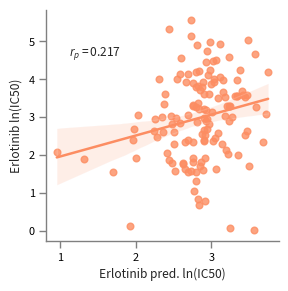

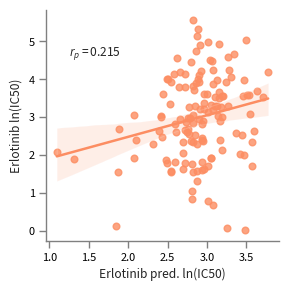

In [39]:
## INDIVIDUAL SCATTER PLOTS
fe = "icovae"
model = "ElasticNet"
drug = "ERLOTINIB"
experiment = "h16"
seed = [10, 20, 30, 40, 50, 60, 70, 80, 90.10]

comp._load_preds(
    fe=fe,
    model=model,
    target=drug,
    dataset="depmap_gdsc",
    experiment=experiment,
    seeds=seed,
    plot_scatter=True,
)

plt.savefig(
    f"./figures/{drug}_{fe}_{model}_{experiment}_scatter.svg", bbox_inches="tight"
)

### 2.1.4 Correlation of latent features with drug response

['PPM1D', 'MDM4', 'POP5', 'VCP', 'RRS1', 'H2AZ1', 'SGO1', 'PSMA2', 'GBF1', 'PSMA6', 'C1ORF109', 'EIF6', 'TTF2', 'ATP6V1D', 'OR4S1', 'DCLRE1B', 'MDM2', 'ISY1', 'MRPL4', 'ALG11', 'RAPGEF1', 'BORCS8', 'RAD9A', 'PSMA5', 'COPB2', 'NIP7', 'SRFBP1', 'POMP', 'PSMC6', 'LMAN1', 'MYSM1', 'RPUSD4']

Dataset created:                   
--------------------------------------------------
Data type                          Size
--------------------------------------------------
x                                  (1450, 6129)
s                                  (1450, 32)
y                                  (1450, 1)
--------------------------------------------------
            Unnamed: 0   ind       z_0       z_1       z_2       z_3  \
ModelID                                                                
ACH-000495           0  1247 -1.616479 -1.316197  0.566982 -0.010688   
ACH-000864           1   372 -0.824238 -0.059649 -0.853357 -0.255366   
ACH-001844           2  1408  0.243283 -0.503592  0.049

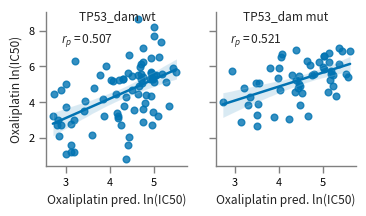

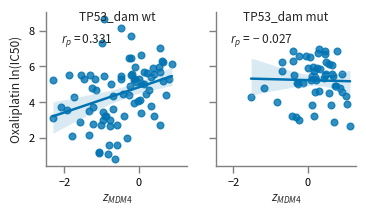

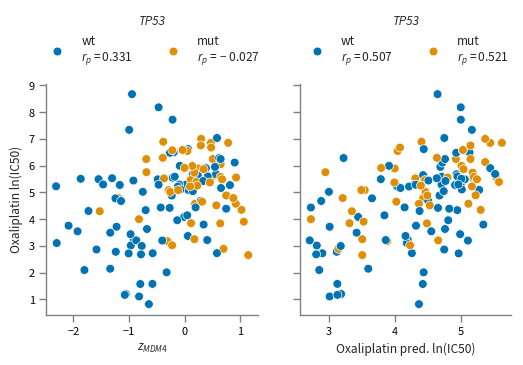

In [ ]:
import json

## DEPENDENCY CAPTURES INFORMATION NOT IN MUTATION STATUS
fe = "icovae"
model = "ElasticNet"
drug = "OXALIPLATIN"
experiment = "h16"
dataset_name = "depmap_gdsc"
gene_1 = "MDM4"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

dim_corrs = []
pred_corrs = []
mut_assocs = []

curr_folder = f"{wd_path}/data/outputs/{dataset_name}/{drug.upper()}/{experiment}/pico/{model}_{fe}"

with open(f"{curr_folder}/args_best.txt") as f:
    args = json.load(f)

constraints = args["constraints"]
print(constraints)

constraints = [constraint.strip() for constraint in constraints]

n_constraints = len(constraints)

# PROCESS DATASET
x, s, c, y, test_samples = process_data(
    dataset=dataset_name, wd_path=wd_path, experiment=experiment
)

dataset_params = {"var_filt_x": 1, "var_filt_s": None}

dataset = Manual(
    x=x, s=s, y=y, constraints=constraints, target=drug, params=dataset_params
)

for seed in seeds:
    gene_mut = "TP53"
    gene_mut_2 = "TP53"
    mut_type = "dam"
    mut_type_2 = "hs"

    pred_dict, test_z, genes = comp._load_preds(
        fe=fe,
        model=model,
        target=drug.upper(),
        dataset="depmap_gdsc",
        experiment=experiment,
        seeds=[seed],
        plot_scatter=False,
        return_z=True,
        return_val_z=False,
    )

    test_z_plot = test_z.copy()

    test_z_plot["ModelID"] = test_z_plot["ind"].apply(
        lambda x: dataset.idx_to_sample[x]
    )
    test_z_plot = test_z_plot.set_index("ModelID")

    print(test_z_plot)

    # Merge mutation data
    test_z_plot = pd.merge(
        test_z_plot, comp.mut_hs, left_index=True, right_index=True, how="left"
    )
    test_z_plot = pd.merge(
        test_z_plot,
        comp.mut_dam,
        left_index=True,
        right_index=True,
        how="left",
        suffixes=["_hs", "_dam"],
    ).dropna(axis=0)

    if mut_type is not None:
        gene_mut = f"{gene_mut}_{mut_type}"

    if gene_mut_2 is None:
        test_z_plot[gene_mut] = test_z_plot[gene_mut] >= 1
        test_z_mut = test_z_plot[test_z_plot[gene_mut] >= 1]
        test_z_wt = test_z_plot[test_z_plot[gene_mut] == 0]
    else:
        gene_mut_2 = f"{gene_mut_2}_{mut_type_2}"
        test_z_plot[gene_mut] = (test_z_plot[gene_mut] >= 1) | (
            test_z_plot[gene_mut_2] >= 1
        )
        test_z_mut = test_z_plot[
            (test_z_plot[gene_mut] >= 1) | (test_z_plot[gene_mut_2] >= 1)
        ]
        test_z_wt = test_z_plot[
            (test_z_plot[gene_mut] == 0) & (test_z_plot[gene_mut_2] == 0)
        ]
    r_mut, _ = pearsonr(test_z_mut["y"], test_z_mut["pred_0"])
    r_wt, _ = pearsonr(test_z_wt["y"], test_z_wt["pred_0"])
    s_mut, _ = spearmanr(test_z_mut["y"], test_z_mut["pred_0"])
    s_wt, _ = spearmanr(test_z_wt["y"], test_z_wt["pred_0"])

    r_all, _ = pearsonr(test_z_plot["y"], test_z_plot["pred_0"])
    s_all, _ = spearmanr(test_z_plot["y"], test_z_plot["pred_0"])

    pred_corrs.append(
        {"r_corr": r_mut, "s_corr": s_mut, "mut_stat": "mut", "seed": seed}
    )
    pred_corrs.append({"r_corr": r_wt, "s_corr": s_wt, "mut_stat": "wt", "seed": seed})
    pred_corrs.append(
        {"r_corr": r_all, "s_corr": s_all, "mut_stat": "all", "seed": seed}
    )

    # Get top corrs for wt and mut
    for i in range(32):
        if i < len(genes):
            dim = rf"$z_{{{genes[i]}}}$"
        else:
            dim = rf"$z_{{{i}}}$"
        # print(f"Gene: {i}")
        r_m, _ = pearsonr(test_z_mut["y"], test_z_mut[f"z_{i}"])
        r_w, _ = pearsonr(test_z_wt["y"], test_z_wt[f"z_{i}"])
        r_a, _ = pearsonr(test_z_plot["y"], test_z_plot[f"z_{i}"])

        s_m, _ = spearmanr(test_z_mut["y"], test_z_mut[f"z_{i}"])
        s_w, _ = spearmanr(test_z_wt["y"], test_z_wt[f"z_{i}"])
        s_a, _ = spearmanr(test_z_plot["y"], test_z_plot[f"z_{i}"])
        # print(f"mut r: {r_m:.3f}")
        # print(f"wt r: {r_w:.3f}")
        dim_corrs.append(
            {"dim": dim, "r_corr": r_m, "s_corr": s_m, "mut_stat": "mut", "seed": seed}
        )
        dim_corrs.append(
            {"dim": dim, "r_corr": r_w, "s_corr": s_w, "mut_stat": "wt", "seed": seed}
        )
        dim_corrs.append(
            {"dim": dim, "r_corr": r_a, "s_corr": s_a, "mut_stat": "all", "seed": seed}
        )


gene_i = genes.index(gene_1)

f, ax = plt.subplots(1, 2, figsize=(4, 2), sharey=True, sharex=True)
sns.regplot(data=test_z_wt, y="y", x="pred_0", ax=ax[0])
sns.regplot(data=test_z_mut, y="y", x="pred_0", ax=ax[1])
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
ax[0].set_ylabel(f"{drug.capitalize()} ln(IC50)")
ax[1].set_ylabel("")
ax[0].set_xlabel(f"{drug.capitalize()} pred. ln(IC50)")
ax[1].set_xlabel(f"{drug.capitalize()} pred. ln(IC50)")
ax[0].text(s=rf"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax[0].transAxes)
ax[1].text(s=rf"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.8, transform=ax[1].transAxes)
ax[0].text(
    s=f"{gene_mut} wt",
    fontweight="regular",
    x=0.5,
    y=0.95,
    transform=ax[0].transAxes,
    horizontalalignment="center",
)
ax[1].text(
    s=f"{gene_mut} mut",
    fontweight="regular",
    x=0.5,
    y=0.95,
    transform=ax[1].transAxes,
    horizontalalignment="center",
)

f, ax = plt.subplots(1, 2, figsize=(4, 2), sharey=True, sharex=True)
r_mut, _ = pearsonr(test_z_mut["y"], test_z_mut[f"z_{gene_i}"])
r_wt, _ = pearsonr(test_z_wt["y"], test_z_wt[f"z_{gene_i}"])
sns.regplot(data=test_z_wt, y="y", x=f"z_{gene_i}", ax=ax[0])
sns.regplot(data=test_z_mut, y="y", x=f"z_{gene_i}", ax=ax[1])
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
ax[0].set_ylabel(f"{drug.capitalize()} ln(IC50)")
ax[1].set_ylabel("")
ax[0].set_xlabel(rf"$z_{{{gene_1}}}$")
ax[1].set_xlabel(rf"$z_{{{gene_1}}}$")
ax[0].text(s=rf"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax[0].transAxes)
ax[1].text(s=rf"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.8, transform=ax[1].transAxes)
ax[0].text(
    s=f"{gene_mut} wt",
    fontweight="regular",
    x=0.5,
    y=0.95,
    transform=ax[0].transAxes,
    horizontalalignment="center",
)
ax[1].text(
    s=f"{gene_mut} mut",
    fontweight="regular",
    x=0.5,
    y=0.95,
    transform=ax[1].transAxes,
    horizontalalignment="center",
)


# DEP AND PRED, COLOURED BY MUT STATUS
with sns.color_palette("colorblind"):
    f, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
    sns.scatterplot(
        data=test_z_plot, y="y", x=f"z_{gene_i}", hue=gene_mut, ax=ax[0], s=40
    )
    sns.despine(ax=ax[0])
    ax[0].set_ylabel(f"{drug.capitalize()} ln(IC50)")
    ax[0].set_xlabel(rf"$z_{{{gene_1}}}$")
    # ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
    # ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
    h, l = ax[0].get_legend_handles_labels()
    ax[0].legend(
        handles=h,
        labels=[f"wt\n$r_{{p}}={r_wt:.3f}$", f"mut\n$r_{{p}}={r_mut:.3f}$"],
        title=gene_mut.split("_")[0],
        bbox_to_anchor=(0.5, 1.35),
        loc="upper center",
        frameon=False,
        fontsize="medium",
        ncol=2,
        title_fontproperties={"style": "italic", "size": "medium"},
    )

    # r_mut, _ = pearsonr(test_z_mut[drug], test_z_mut[f"z_{gene_j}"])
    # r_wt, _ = pearsonr(test_z_wt[drug], test_z_wt[f"z_{gene_j}"])
    # sns.scatterplot(data=test_z_plot, y=drug.upper(), x=f"z_{gene_j}", hue=gene_mut, ax=ax[1], s=40)
    # sns.despine(ax=ax[1])
    # ax[1].set_ylabel(f"{drug.capitalize()} ln(IC50)")
    # ax[1].set_xlabel(fr"$z_{{{gene_2}}}$")
    # #ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
    # #ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
    # h,l = ax[1].get_legend_handles_labels()
    # ax[1].legend(handles=h, labels=[f"wt $r_{{p}} = {r_wt:.3f}$", f"mut $r_{{p}} = {r_mut:.3f}$"], title=gene_mut, fontsize="small", title_fontproperties={"style": "italic", "size":"small"})

    r_mut, _ = pearsonr(test_z_mut["y"], test_z_mut["pred_0"])
    r_wt, _ = pearsonr(test_z_wt["y"], test_z_wt["pred_0"])

    s_mut, _ = spearmanr(test_z_mut["y"], test_z_mut["pred_0"])
    s_wt, _ = spearmanr(test_z_wt["y"], test_z_wt["pred_0"])

    sns.scatterplot(data=test_z_plot, y="y", x="pred_0", hue=gene_mut, ax=ax[1], s=40)
    sns.despine(ax=ax[1])
    ax[1].set_ylabel(f"{drug.capitalize()} ln(IC50)")
    ax[1].set_xlabel(f"{drug.capitalize()} pred. ln(IC50)")
    # ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
    # ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
    h, l = ax[1].get_legend_handles_labels()
    ax[1].legend(
        handles=h,
        labels=[f"wt\n$r_{{p}}={r_wt:.3f}$", f"mut\n$r_{{p}}={r_mut:.3f}$"],
        title=gene_mut.split("_")[0],
        bbox_to_anchor=(0.5, 1.35),
        loc="upper center",
        frameon=False,
        fontsize="medium",
        ncol=2,
        title_fontproperties={"style": "italic", "size": "medium"},
    )
    plt.savefig(f"./figures/mut_wt_pred_{drug}_{gene_i}.svg", bbox_inches="tight")
    plt.savefig(
        f"./figures/mut_wt_pred_{drug}_{gene_i}.png", bbox_inches="tight", dpi=600
    )


## TWO DEPS, COLOURED BY RESP

# f, ax = plt.subplots(1,2, figsize=(9,3), sharey=True, sharex=True)
# sns.scatterplot(data=test_z_wt, y=f"z_{gene_j}", x=f"z_{gene_i}", hue=gene_mut, size=drug.upper(), sizes=(1,50), ax=ax[0], s=40)
# sns.despine(ax=ax[0])
# ax[0].set_ylabel(fr"$z_{{{gene_2}}}$")
# ax[0].set_xlabel(fr"$z_{{{gene_1}}}$")
# #ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
# #ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
# #h,l = ax[0].get_legend_handles_labels()
# ax[0].legend(handles=h, labels=["wt", "mut"], title=gene_mut, fontsize="small", title_fontproperties={"style": "italic", "size":"small"})

# sns.scatterplot(data=test_z_mut, y=f"z_{gene_j}", x=f"z_{gene_i}", hue=gene_mut, size=drug.upper(), sizes=(1,50), ax=ax[1], s=40)
# sns.despine(ax=ax[1])
# ax[1].set_ylabel(fr"$z_{{{gene_2}}}$")
# ax[1].set_xlabel(fr"$z_{{{gene_1}}}$")
# #ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
# #ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
# #h,l = ax[0].get_legend_handles_labels()
# ax[1].legend(handles=h, labels=["wt", "mut"], title=gene_mut, fontsize="small", title_fontproperties={"style": "italic", "size":"small"})

# r_mut, _ = pearsonr(test_z_mut[drug], test_z_mut[f"z_{gene_j}"])
# r_wt, _ = pearsonr(test_z_wt[drug], test_z_wt[f"z_{gene_j}"])
# sns.scatterplot(data=test_z_plot, y=drug.upper(), x=f"z_{gene_j}", hue=gene_mut, ax=ax[1], s=40)
# sns.despine(ax=ax[1])
# ax[1].set_ylabel(f"{drug.capitalize()} ln(IC50)")
# ax[1].set_xlabel(fr"$z_{{{gene_2}}}$")
# #ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
# #ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
# h,l = ax[1].get_legend_handles_labels()
# ax[1].legend(handles=h, labels=[f"wt $r_{{p}} = {r_wt:.3f}$", f"mut $r_{{p}} = {r_mut:.3f}$"], title=gene_mut, fontsize="small", title_fontproperties={"style": "italic", "size":"small"})

# r_mut, _ = pearsonr(test_z_mut[drug], test_z_mut["pred_0"])
# r_wt, _ = pearsonr(test_z_wt[drug], test_z_wt["pred_0"])
# sns.scatterplot(data=test_z_plot, y=drug.upper(), x=f"pred_0", hue=gene_mut, ax=ax[2], s=40)
# sns.despine(ax=ax[2])
# ax[2].set_ylabel(f"{drug.capitalize()} ln(IC50)")
# ax[2].set_xlabel(f"{drug.capitalize()} pred. ln(IC50)")
# #ax.text(s=fr"$r_{{p}} = {r_wt:.3f}$", x=0.1, y=0.8, transform=ax.transAxes)
# #ax.text(s=fr"$r_{{p}} = {r_mut:.3f}$", x=0.1, y=0.7, transform=ax.transAxes)
# h,l = ax[2].get_legend_handles_labels()
# ax[2].legend(handles=h, labels=[f"wt $r_{{p}} = {r_wt:.3f}$", f"mut $r_{{p}} = {r_mut:.3f}$"], title=gene_mut, fontsize="small", title_fontproperties={"style": "italic", "size":"small"})
# #plt.savefig(f"./figures/mut_wt_pred_{drug}_{gene_i}.svg", bbox_inches="tight")
# #plt.savefig(f"./figures/mut_wt_pred_{drug}_{gene_i}.png", bbox_inches="tight", dpi=600)

      r_corr    s_corr mut_stat  seed
0   0.584619  0.575986      mut    10
1   0.538343  0.535551       wt    10
2   0.556078  0.556166      all    10
3   0.590417  0.584067      mut    20
4   0.474724  0.479936       wt    20
5   0.514646  0.526740      all    20
6   0.539505  0.562340      mut    30
7   0.546460  0.545412       wt    30
8   0.556981  0.569539      all    30
9   0.573535  0.569506      mut    40
10  0.560273  0.553161       wt    40
11  0.563349  0.562192      all    40
12  0.551735  0.551134      mut    50
13  0.515629  0.526540       wt    50
14  0.524073  0.530733      all    50
15  0.568607  0.567372      mut    60
16  0.481695  0.456863       wt    60
17  0.494738  0.496174      all    60
18  0.550147  0.537107      mut    70
19  0.538439  0.535029       wt    70
20  0.542878  0.544578      all    70
21  0.504375  0.490757      mut    80
22  0.483065  0.459518       wt    80
23  0.495821  0.486222      all    80
24  0.532954  0.536040      mut    90
25  0.548095

/tmp/ipykernel_539177/1206607116.py:36: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_yticks([], [])
/tmp/ipykernel_539177/1206607116.py:53: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_539177/1206607116.py:53: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_539177/1206607116.py:53: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(


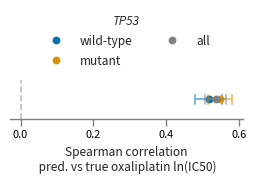

In [24]:
# PRED CORR WITH DRUG RESPONSE
pred_corrs_df = pd.DataFrame(pred_corrs)
print(pred_corrs_df)
pred_corrs_df["abs_corr"] = pred_corrs_df["s_corr"].abs()

pal = sns.color_palette("colorblind")
palette = {"mut": pal[1], "wt": pal[0], "all": "grey"}

pred_corrs_mean = (
    pred_corrs_df[pred_corrs_df["mut_stat"] == "all"]
    .groupby(["mut_stat"])
    .mean()
    .sort_values("abs_corr", ascending=False)
    .reset_index()
    .head(15)
)

f, ax = plt.subplots(1, 1, figsize=(3, 0.5))
ax.axvline(0, color="grey", linestyle="--", alpha=0.5)
sns.pointplot(
    data=pred_corrs_df,
    x="s_corr",
    hue="mut_stat",
    hue_order=["wt", "mut", "all"],
    palette=palette,
    linestyle="none",
    markersize=4,
    errorbar=("sd", 1),
    capsize=0.25,
    err_kws={"linewidth": 1.5, "alpha": 0.5},
)
sns.despine(ax=ax, left=True)
ax.set_ylabel("")
ax.set_xlabel(f"Spearman correlation\n pred. vs true {drug.lower()} ln(IC50)")
ax.tick_params(axis="y", which="major", labelsize=10)
ax.set_yticks([], [])
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=["wild-type", "mutant", "all"],
    title=gene_mut.split("_")[0],
    fontsize="medium",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 3),
    loc="upper center",
    title_fontproperties={"style": "italic", "size": "medium"},
)
# for label in ax.get_xticklabels():
#   label.set_rotation(60)
#   label.set_ha("right")
#   label.set_rotation_mode("anchor")
plt.savefig(
    f"./figures/mut_wt_pred_{drug}_{gene_mut}.png", dpi=600, bbox_inches="tight"
)
plt.savefig(f"./figures/mut_wt_pred_{drug}_{gene_mut}.svg", bbox_inches="tight")

                           r_corr    s_corr  seed
dim            mut_stat                          
$z_{TTF2}$     wt        0.565237  0.584661  55.0
$z_{H2AZ1}$    wt        0.531421  0.559223  55.0
               all       0.515617  0.537138  55.0
               mut       0.497930  0.492838  55.0
$z_{TTF2}$     all       0.495537  0.484557  55.0
$z_{POP5}$     wt        0.411735  0.437031  55.0
$z_{PPM1D}$    wt        0.375717  0.431430  55.0
$z_{EIF6}$     all       0.378624  0.417338  55.0
               mut       0.389716  0.405291  55.0
               wt        0.362144  0.402336  55.0
$z_{DCLRE1B}$  wt        0.340648  0.400660  55.0
$z_{MRPL4}$    wt        0.380372  0.393679  55.0
$z_{MDM4}$     wt        0.303701  0.370188  55.0
$z_{RAD9A}$    mut       0.338037  0.362264  55.0
$z_{PPM1D}$    all       0.375285  0.360340  55.0
$z_{RPUSD4}$   wt        0.328777  0.353213  55.0
$z_{POP5}$     all       0.348381  0.352130  55.0
$z_{NIP7}$     wt        0.313324  0.350710  55.0


/tmp/ipykernel_539177/2322612216.py:59: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(
/tmp/ipykernel_539177/2322612216.py:59: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(


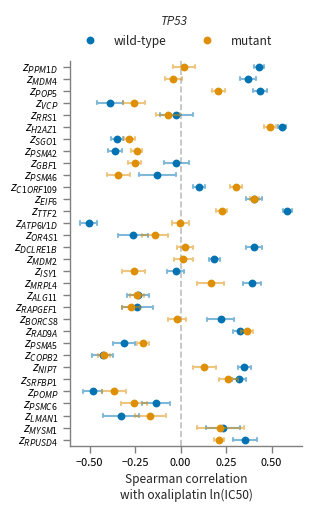

: 

In [ ]:
# MUT WT Z CORR WITH DRUG RESPONSE
dim_corrs_df = pd.DataFrame(dim_corrs)
print(
    dim_corrs_df.groupby(["dim", "mut_stat"])
    .mean()
    .sort_values("s_corr", ascending=False)
    .head(50)
)
print(dim_corrs_df.groupby(["dim", "mut_stat"]).mean().sort_values("s_corr").head(50))
dim_corrs_df["abs_corr"] = dim_corrs_df["s_corr"].abs()


dim_corrs_mean = (
    dim_corrs_df[dim_corrs_df["mut_stat"] == "all"]
    .groupby(["dim", "mut_stat"])
    .mean()
    .sort_values("abs_corr", ascending=False)
    .reset_index()
    .head(15)
)

f, ax = plt.subplots(1, 1, figsize=(3, 5))
ax.axvline(0, color="grey", linestyle="--", alpha=0.5)
sns.pointplot(
    data=dim_corrs_df,
    x="s_corr",
    y="dim",
    hue="mut_stat",
    hue_order=["wt", "mut"],
    palette=palette,
    linestyle="none",
    markersize=4,
    errorbar=("sd", 1),
    capsize=0.25,
    err_kws={"linewidth": 1.5, "alpha": 0.5},
)
sns.despine(ax=ax)
ax.set_ylabel("")
ax.set_xlabel(f"Spearman correlation\nwith {drug.lower()} ln(IC50)")
ax.tick_params(axis="y", which="major", labelsize=10)
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=["wild-type", "mutant"],
    title=gene_mut.split("_")[0],
    fontsize="medium",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.45, 1.15),
    loc="upper center",
    title_fontproperties={"style": "italic", "size": "medium"},
)

plt.savefig(
    f"./figures/mut_wt_corr_{drug}_{gene_mut}.png", dpi=600, bbox_inches="tight"
)
plt.savefig(f"./figures/mut_wt_corr_{drug}_{gene_mut}.svg", bbox_inches="tight")

### 2.1.5 Permutation feature importance

In [ ]:
### FEATURE IMPORTANCE
from utils.comp_utils import calculate_feat_imps

target = "LAPATINIB"
fe = "icovae"
model = "ElasticNet"
experiment = "h16"
dataset_name = "depmap_gdsc"
seeds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
train = False

pred_dict_list, constraints, confounders, pi_df = calculate_feat_imps(
    enc=fe,
    reg=model,
    model_path=f"{wd_path}/data/outputs/{dataset_name}/{target.upper()}/{experiment}/pico/{model}_{fe}",
    target="",
    seeds=seeds,
    train=train,
)

{'target': 'LAPATINIB', 'dataset': 'depmap_gdsc', 'enc': 'iCoVAE', 'reg': 'ElasticNet', 'constraints': ['ERBB2', 'MIEN1', 'EGFR', 'STX4', 'ERBB3', 'ITGAV', 'NEUROD2', 'ITGB5', 'CDK8', 'STXBP3', 'TP63', 'ELMO2', 'CAP1', 'BIRC6', 'PTPN23', 'GRHL2'], 'confounders': None, 'duration_event': None, 'strata': None, 'seed': 10, 'data_dir': './data', 'norm': False, 'lindec': False, 'filt': 'uni_var', 'experiment': 'h16', 'cuda': False, 'norep': False, 'newstudy': False, 'enc_path': '/home/dk538/rds/hpc-work/graphdep/data/outputs/depmap_gdsc/LAPATINIB/h16/icovae', 'test_samples': ['ACH-000011', 'ACH-000016', 'ACH-000018', 'ACH-000026', 'ACH-000039', 'ACH-000041', 'ACH-000043', 'ACH-000046', 'ACH-000049', 'ACH-000052', 'ACH-000058', 'ACH-000063', 'ACH-000071', 'ACH-000078', 'ACH-000079', 'ACH-000082', 'ACH-000083', 'ACH-000086', 'ACH-000087', 'ACH-000088', 'ACH-000090', 'ACH-000092', 'ACH-000096', 'ACH-000099', 'ACH-000115', 'ACH-000119', 'ACH-000120', 'ACH-000125', 'ACH-000127', 'ACH-000131', 'AC

               seed    r_perm    s_perm  rmse_perm         r         s  \
dim                                                                      
$z_{EGFR}$     55.0  0.564761  0.539794   1.327673  0.609988  0.584994   
$z_{20}$       55.0  0.580768  0.549788   1.311289  0.609988  0.584994   
$z_{28}$       55.0  0.587683  0.560155   1.299878  0.609988  0.584994   
$z_{CDK8}$     55.0  0.590639  0.560153   1.298000  0.609988  0.584994   
$z_{24}$       55.0  0.589980  0.562324   1.297694  0.609988  0.584994   
$z_{22}$       55.0  0.591525  0.563902   1.296200  0.609988  0.584994   
$z_{21}$       55.0  0.594820  0.565670   1.291863  0.609988  0.584994   
$z_{27}$       55.0  0.594663  0.567128   1.292917  0.609988  0.584994   
$z_{NEUROD2}$  55.0  0.591929  0.567821   1.297314  0.609988  0.584994   
$z_{BIRC6}$    55.0  0.590407  0.568039   1.298288  0.609988  0.584994   
$z_{PTPN23}$   55.0  0.591338  0.568237   1.297132  0.609988  0.584994   
$z_{MIEN1}$    55.0  0.582340  0.56844

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
/tmp/ipykernel_2543302/1706842277.py:131: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[0, 1].set_yticks([], [])


               seed    r_perm    s_perm  rmse_perm         r         s  \
dim                                                                      
$z_{EGFR}$     55.0  0.564761  0.539794   1.327673  0.609988  0.584994   
$z_{20}$       55.0  0.580768  0.549788   1.311289  0.609988  0.584994   
$z_{MIEN1}$    55.0  0.582340  0.568440   1.308049  0.609988  0.584994   
$z_{ERBB2}$    55.0  0.585763  0.569022   1.304665  0.609988  0.584994   
$z_{28}$       55.0  0.587683  0.560155   1.299878  0.609988  0.584994   
$z_{24}$       55.0  0.589980  0.562324   1.297694  0.609988  0.584994   
$z_{BIRC6}$    55.0  0.590407  0.568039   1.298288  0.609988  0.584994   
$z_{CDK8}$     55.0  0.590639  0.560153   1.298000  0.609988  0.584994   
$z_{PTPN23}$   55.0  0.591338  0.568237   1.297132  0.609988  0.584994   
$z_{22}$       55.0  0.591525  0.563902   1.296200  0.609988  0.584994   
$z_{NEUROD2}$  55.0  0.591929  0.567821   1.297314  0.609988  0.584994   
$z_{27}$       55.0  0.594663  0.56712

/tmp/ipykernel_2543302/1706842277.py:131: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[0, 1].set_yticks([], [])


               seed    r_perm    s_perm  rmse_perm         r         s  \
dim                                                                      
$z_{ELMO2}$    55.0  0.609523  0.584695   1.275344  0.609988  0.584994   
$z_{STXBP3}$   55.0  0.609541  0.585643   1.275557  0.609988  0.584994   
$z_{ERBB3}$    55.0  0.608930  0.584346   1.276336  0.609988  0.584994   
$z_{STX4}$     55.0  0.608828  0.585413   1.276648  0.609988  0.584994   
$z_{GRHL2}$    55.0  0.607478  0.582402   1.277689  0.609988  0.584994   
$z_{ITGB5}$    55.0  0.606478  0.582403   1.279631  0.609988  0.584994   
$z_{23}$       55.0  0.604844  0.580387   1.280728  0.609988  0.584994   
$z_{TP63}$     55.0  0.605367  0.581630   1.280809  0.609988  0.584994   
$z_{26}$       55.0  0.604417  0.578507   1.281396  0.609988  0.584994   
$z_{17}$       55.0  0.602984  0.577016   1.282671  0.609988  0.584994   
$z_{16}$       55.0  0.602577  0.576372   1.283365  0.609988  0.584994   
$z_{29}$       55.0  0.602090  0.57519

/tmp/ipykernel_2543302/1706842277.py:131: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[0, 1].set_yticks([], [])


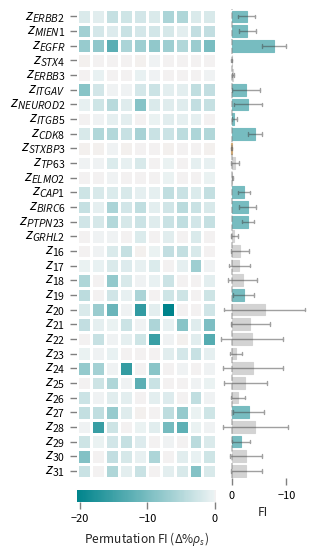

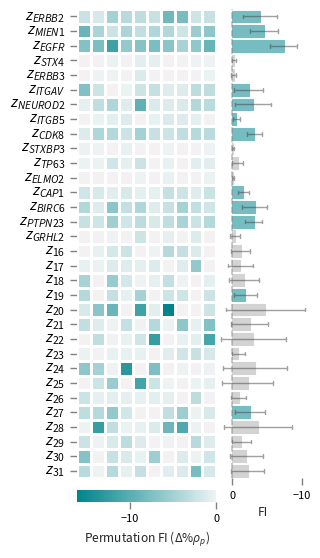

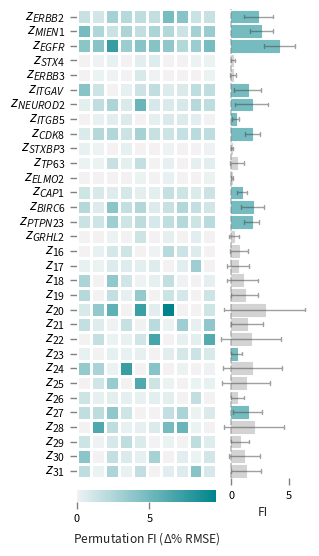

In [ ]:
# PERMUTATION FEATURE IMPORTANCE
from matplotlib.colors import rgb_to_hsv

n_feats = len(constraints) * 2
for metric in ["s", "r", "rmse"]:
    pal = sns.color_palette("colorblind")
    f, ax = plt.subplots(
        2,
        2,
        figsize=(3, n_feats / 5),
        sharey=False,
        gridspec_kw={"width_ratios": [6, 4], "height_ratios": [40, 1]},
    )
    pi_df_plot = pi_df.copy()
    pi_df_plot["fi_r"] = (
        100 * (pi_df_plot["r_perm"] - pi_df_plot["r"]) / (pi_df_plot["r"])
    )
    pi_df_plot["fi_s"] = (
        100 * (pi_df_plot["s_perm"] - pi_df_plot["s"]) / (pi_df_plot["s"])
    )
    pi_df_plot["fi_rmse"] = (
        100 * (pi_df_plot["rmse_perm"] - pi_df_plot["rmse"]) / pi_df_plot["rmse"]
    )
    pi_df_plot["dim"] = pi_df_plot["dim"].apply(lambda x: x.split("_")[1])
    pi_df_plot["dim"] = pi_df_plot["dim"].apply(lambda x: rf"$z_{{{x}}}$")

    # Group by dim and seed and take mean over perturbation iterations
    pi_df_plot = pi_df_plot.groupby(["dim", "seed"]).mean().reset_index()

    plot_order = (
        pi_df_plot.groupby("dim").mean().sort_values(by=f"{metric}_perm").index.tolist()
    )
    pi_df_plot = pi_df_plot[pi_df_plot["dim"].isin(plot_order[:n_feats])]

    pi_df_plot_hm = (
        pd.melt(
            pi_df_plot[["dim", f"fi_{metric}", "seed"]],
            id_vars=["dim", "seed"],
            value_vars=[f"fi_{metric}"],
        )
        .drop("variable", axis=1)
        .sort_values("value")
        .reset_index()
    )

    pi_df_plot_hm = pi_df_plot_hm.pivot_table(
        index="dim", columns="seed", values="value", sort=True
    )

    # Plot dimensions in order
    plot_order = [rf"$z_{{{gene}}}$" for gene in constraints]
    plot_order = plot_order + [
        rf"$z_{{{i + len(constraints)}}}$" for i in range(n_feats - len(constraints))
    ]
    # Plot dimensions in order of importance

    pi_df_plot_hm = pi_df_plot_hm.loc[plot_order]

    pi_df_plot = pi_df_plot.set_index("dim").loc[plot_order].reset_index()

    print(pi_df_plot.groupby(["dim"]).mean().sort_values(f"fi_{metric}"))

    if metric == "rmse":
        pal_cm = sns.diverging_palette(
            rgb_to_hsv(pal[1])[0] * 360,
            rgb_to_hsv(pal[0])[0] * 360,
            s=100,
            center="light",
            as_cmap=True,
        )
    else:
        pal_cm = sns.diverging_palette(
            rgb_to_hsv(pal[0])[0] * 360,
            rgb_to_hsv(pal[1])[0] * 360,
            s=100,
            center="light",
            as_cmap=True,
        )

    # HEATMAP
    cbar_labels = {
        "r": r"$\Delta \% \rho_{{p}}$",
        "s": r"$\Delta \% \rho_{{s}}$",
        "rmse": r"$\Delta\%$ RMSE",
    }

    sns.heatmap(
        pi_df_plot_hm,
        yticklabels=True,
        square=False,
        linewidths=1,
        cmap=pal_cm,
        center=0,
        ax=ax[0, 0],
        cbar_ax=ax[1, 0],
        cbar_kws={
            "orientation": "horizontal",
            "fraction": 0.02,
            "label": f"Permutation FI ({cbar_labels[metric]})",
            "use_gridspec": False,
        },
    )
    sns.despine(ax=ax[0, 0], bottom=True, left=True)

    ax[0, 0].set_ylabel("")
    ax[0, 0].set_xlabel("")

    ax[0, 0].set_xticks([], [])
    ax[0, 0].tick_params(axis="y", which="major", labelsize=12)

    ax[0, 0].set_title("")

    # BARPLOT
    sns.barplot(
        data=pi_df_plot,
        y="dim",
        x=f"fi_{metric}",
        estimator="mean",
        errorbar=("sd", 1),
        ax=ax[0, 1],
        capsize=0.25,
        dodge=False,
        err_kws={"linewidth": 1, "alpha": 0.5},
    )
    ax[0, 1].axvline(0, linestyle="--", color="grey", alpha=0.5)
    ax[0, 1].set_ylim(len(plot_order) - 0.5, -0.5)
    ax[0, 1].set_yticks([], [])
    ax[0, 1].set_ylabel("")
    ax[0, 1].set_xlabel("FI")

    for i, bar in enumerate(ax[0, 1].patches):
        if bar.get_height() > 0:
            if (ax[0, 1].lines[i].get_xdata()[-1] > 0) and (
                ax[0, 1].lines[i].get_xdata()[0] > 0
            ):
                bar.set_color(pal_cm(0.75))
            elif (ax[0, 1].lines[i].get_xdata()[-1] < 0) and (
                ax[0, 1].lines[i].get_xdata()[0] < 0
            ):
                bar.set_color(pal_cm(0.25))
            else:
                bar.set_color("lightgrey")

    if metric != "rmse":
        ax[0, 1].invert_xaxis()

    sns.despine(ax=ax[0, 1], bottom=True, left=True)
    sns.despine(ax=ax[1, 0], bottom=True, left=True)
    ax[1, 1].axis("off")

    plt.subplots_adjust(wspace=0.00, hspace=0.05)

    if train:
        plt.savefig(
            f"./figures/fi_{target}_{fe}_{model}_{experiment}_{metric}_train.svg",
            bbox_inches="tight",
        )
        plt.savefig(
            f"./figures/fi_{target}_{fe}_{model}_{experiment}_{metric}_train.png",
            bbox_inches="tight",
            dpi=600,
        )
    else:
        plt.savefig(
            f"./figures/fi_{target}_{fe}_{model}_{experiment}_{metric}.svg",
            bbox_inches="tight",
        )
        plt.savefig(
            f"./figures/fi_{target}_{fe}_{model}_{experiment}_{metric}.png",
            bbox_inches="tight",
            dpi=600,
        )

In [16]:
pi_df_summ = pi_df_plot.groupby(["dim"]).mean().sort_values("fi_s")
if train:
    pi_df_summ.to_csv(
        f"./figures/fi_{target}_{fe}_{model}_{experiment}_{metric}_train.csv"
    )
else:
    pi_df_summ.to_csv(f"./figures/fi_{target}_{fe}_{model}_{experiment}_{metric}.csv")

pi_df_summ.head(50)

,seed,r_perm,s_perm,rmse_perm,r,s,rmse,iter,fi_r,fi_s,fi_rmse
dim,,,,,,,,,,,
$z_{TXNRD1}$,55.0,0.494513,0.494030,1.560604,0.528458,0.531458,1.530346,49.5,-6.463570e+00,-7.049244,1.974047e+00
$z_{TLN1}$,55.0,0.498803,0.507416,1.554274,0.528458,0.531458,1.530346,49.5,-5.703912e+00,-4.549789,1.553394e+00
$z_{RAD9A}$,55.0,0.521769,0.518616,1.537768,0.528458,0.531458,1.530346,49.5,-1.269137e+00,-2.426100,4.852672e-01
$z_{CINP}$,55.0,0.517783,0.520470,1.539152,0.528458,0.531458,1.530346,49.5,-2.026992e+00,-2.070144,5.747215e-01
$z_{CABIN1}$,55.0,0.521416,0.522815,1.532780,0.528458,0.531458,1.530346,49.5,-1.332973e+00,-1.626412,1.608100e-01
$z_{44}$,55.0,0.518889,0.523588,1.541232,0.528458,0.531458,1.530346,49.5,-1.799394e+00,-1.473126,7.167719e-01
$z_{ILK}$,55.0,0.521528,0.525172,1.536636,0.528458,0.531458,1.530346,49.5,-1.300227e+00,-1.180926,4.132810e-01
$z_{SRSF3}$,55.0,0.525576,0.525864,1.532622,0.528458,0.531458,1.530346,49.5,-5.412349e-01,-1.050522,1.491905e-01
$z_{SFTPA1}$,55.0,0.519300,0.526046,1.540493,0.528458,0.531458,1.530346,49.5,-1.736697e+00,-1.017994,6.638003e-01
